# EC500 - Group 6 - Denoising CT Images 
**Avantika Kothandaraman, Caiwei Zhang, Long Chen**

## Section-1: Installing the necessary packages

In [1]:
pip install pynrrd

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install SimpleITK

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
!python -c "import monai" || pip install -q "monai"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [4]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torch.optim as optim
import os
import nibabel as nib
import nrrd
from torchvision.datasets import ImageFolder
import SimpleITK as sitk
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import monai.transforms as mTransforms
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    Compose
)
from tqdm import tqdm
from scipy import ndimage

## Section-2: Initial data inspection

In [5]:
# initializing directory of dataset
data_dir = '/projectnb/ec500kb/projects/Project6/scans'

In [6]:
# looping through for inspection
count = 0
dims = []
sizes = []
shapes = []
    
for filename in os.listdir(data_dir):

    if filename.endswith('.nrrd'):
        count += 1
        img, header = nrrd.read(os.path.join(data_dir,filename))
        dims.append(img.ndim)
        sizes.append(img.size)
        shapes.append(img.shape)
        
dims_check = all(dim == dims[0] for dim in dims)
sizes_check = all(size == sizes[0] for size in sizes)
shapes_check = all(shape == shapes[0] for shape in shapes)

if dims_check and sizes_check and shapes_check:
    print('Dimensions, shapes and sizes are the same for all images')
else:
    print('Dimensions, shapes and sizes NOT UNIFORM')
    
print('Total number of images in the dataset is {}'.format(count))

Dimensions, shapes and sizes NOT UNIFORM
Total number of images in the dataset is 30


In [7]:
# checking the 3D Nature of the image to analyse the axis preferred

def maximum_intensity_projection(volume, axis=0):
    return np.max(volume, axis=axis)

# Perform Maximum Intensity Projection along the z-axis (axis=0)
volume = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_std.nrrd')))
mip_image = maximum_intensity_projection(volume, axis=1)
#mip_image = ndimage.rotate(mip_image, 90, reshape=False)


# Display the resulting 2D image
#plt.imshow(mip_image, cmap='gray')
#plt.colorbar()
#plt.show()

print(volume.shape)
print(mip_image.shape)

volume1 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_noise.nrrd')))
mip_image1 = maximum_intensity_projection(volume1, axis=1)
print(volume1.shape)
print(mip_image1.shape)

volume2 = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_std.nrrd')))
mip_image2 = maximum_intensity_projection(volume2, axis=1)
print(volume2.shape)
print(mip_image2.shape)

#resize = transforms.Resize((64,64))
#r1, r2, r3 = resize(mip_image), resize(mip_image1), resize(mip_image2)
#print(r1.shape,r2.shape,r3.shape)

(560, 512, 512)
(560, 512)
(560, 512, 512)
(560, 512)
(560, 512, 512)
(560, 512)


(560, 512, 512)
(560, 512)
torch.Size([1, 512, 512])


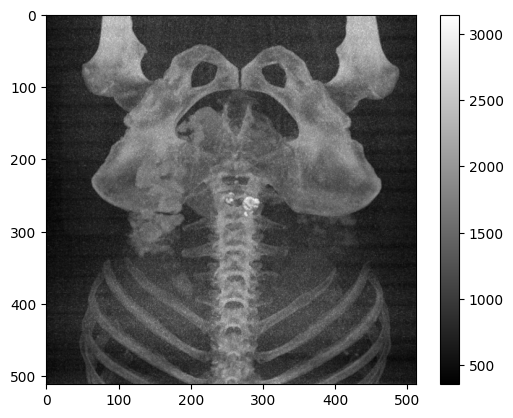

In [8]:
# running experiments to see the kind of transformation that is to be applied before giving as inout to the UNet

volume = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_signal.nrrd')))
volume1 = maximum_intensity_projection(volume, axis=1)

noise = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(data_dir,'L067_noise.nrrd')))
noise1 = maximum_intensity_projection(noise, axis=1)

print(volume.shape)
print(volume1.shape)

trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512,512))
])

volume2 = trans(volume1)
noise2 = trans(noise1)

print(volume2.shape)

#plt.imshow(volume2.squeeze().cpu().numpy(), cmap='gray')
#plt.colorbar()
#plt.show()

#k = random.uniform(0,5)
ct_generated = volume2 + (5*noise2)
plt.imshow(ct_generated.squeeze().cpu().numpy(), cmap='gray')
plt.colorbar()
plt.show()


In [9]:
print(dims)

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [10]:
print(sizes)

[83361792, 83361792, 215744512, 137887744, 159907840, 215744512, 157286400, 137625600, 146800640, 224395264, 146800640, 159907840, 157286400, 159907840, 153354240, 83361792, 137625600, 137887744, 137887744, 215744512, 137625600, 157286400, 224395264, 139722752, 153354240, 139722752, 146800640, 139722752, 153354240, 224395264]


In [11]:
print(shapes)

[(512, 512, 318), (512, 512, 318), (512, 512, 823), (512, 512, 526), (512, 512, 610), (512, 512, 823), (512, 512, 600), (512, 512, 525), (512, 512, 560), (512, 512, 856), (512, 512, 560), (512, 512, 610), (512, 512, 600), (512, 512, 610), (512, 512, 585), (512, 512, 318), (512, 512, 525), (512, 512, 526), (512, 512, 526), (512, 512, 823), (512, 512, 525), (512, 512, 600), (512, 512, 856), (512, 512, 533), (512, 512, 585), (512, 512, 533), (512, 512, 560), (512, 512, 533), (512, 512, 585), (512, 512, 856)]


#### It can be seen that the dimensions are the same throughout (3D). However, the shapes and sizes differ somewhat. 

## Step-3: Creating a Custom Dataset to fix these issues

In [12]:
# creating a Custom Dataset to load the images

class CustomData(torch.utils.data.Dataset):
    
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.data = []
        self.transform = transform
        
        for file in os.listdir(self.root_dir):
            if file.endswith('signal.nrrd'):
                image_id = file.split('_')[0] # this is to extract the image id (ex., L067)
                
                # reading as .nrrd images and converting to 2D
                signal_nrrd = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(self.root_dir, file)))
                noise_nrrd = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(self.root_dir, f"{image_id}_noise.nrrd")))
                std_nrrd = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(self.root_dir, f"{image_id}_std.nrrd")))
                
                signal_nrrd = np.max(signal_nrrd, axis=1)
                noise_nrrd = np.max(noise_nrrd, axis=1)
                std_nrrd = np.max(std_nrrd, axis=1)
                
                #
                trans = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((64,64))
                ])
                
                # converting to PyTorch tensors and resizing
                signal = trans(signal_nrrd)
                noise = trans(noise_nrrd)
                std = trans(std_nrrd)
               
                # generating new images with added noise
                k = random.uniform(0,5)
                ct_generated = signal + (k*noise)

                # applying transforms if specified
                if self.transform:
                    std = self.transform(std)
                    ct_generated = self.transform(ct_generated)
                        
                # store the images in a dictionary format
                self.data.append({'ct_generated' : ct_generated,
                                  'std_map' : std})
                
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [13]:
# applying transforms for data augmentation

aug_transform = Compose([
    #mTransforms.Resize((64,64)),
    #mTransforms.RandFlip(spatial_axis = 0, prob = 0.5),
    mTransforms.RandRotate(range_x=(-np.pi/12, np.pi/12), prob = 0.5, keep_size = True)
])

In [14]:
custom_dataset = CustomData(root_dir=data_dir, transform=aug_transform)

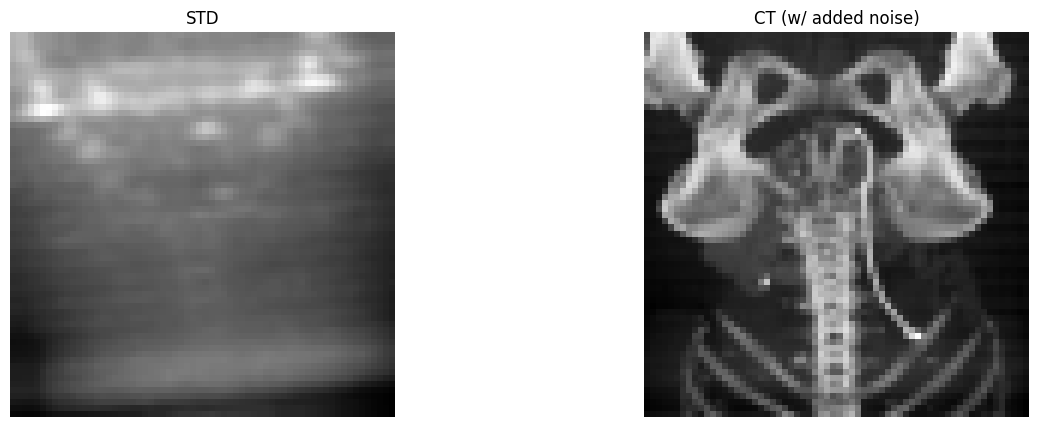

In [15]:
# Plotting a random entry in the dataset

first_entry = custom_dataset[3]

# Plot the images
plt.figure(figsize=(15, 5))

# Plot the std image
plt.subplot(1, 2, 1)
plt.imshow(first_entry['std_map'][0], cmap='gray')
plt.title('STD')
plt.axis('off')

# Plot the std image
plt.subplot(1, 2, 2)
plt.imshow(first_entry['ct_generated'][0], cmap='gray')
plt.title('CT (w/ added noise)')
plt.axis('off')

plt.show()

### Train-test-validation split

In [16]:
# splitting into train-test-validation sets (80-10-10)

train_data, testval_data = train_test_split(custom_dataset, test_size=0.2, random_state=42)

test_data, val_data = train_test_split(testval_data, test_size=0.5, random_state=42)

# creating DataLoader objects for train, validation, and test sets
train_loader = DataLoader(train_data, batch_size=5, shuffle=True, num_workers = 10)
val_loader = DataLoader(val_data, batch_size=5)
test_loader = DataLoader(test_data, batch_size=5)

In [17]:
# Function to print the size of DataLoader
def print_dataloader_sizes(loader, name):
    # Total number of samples
    total_samples = len(loader.dataset)
    
    # Number of batches
    num_batches = len(loader)
    
    # Assuming all batches have the same size except possibly the last one
    batch_size = loader.batch_size
    
    print(f'{name} DataLoader has:')
    print(f'  Total samples: {total_samples}')
    print(f'  Number of batches: {num_batches}')
    print(f'  Batch size: {batch_size}')
    if total_samples % batch_size != 0:
        print(f'  Last batch size: {total_samples % batch_size}')
    else:
        print(f'  All batches have the same size')

# Checking sizes for each DataLoader
print_dataloader_sizes(train_loader, 'Train')
print_dataloader_sizes(val_loader, 'Validation')
print_dataloader_sizes(test_loader, 'Test')


Train DataLoader has:
  Total samples: 8
  Number of batches: 2
  Batch size: 5
  Last batch size: 3
Validation DataLoader has:
  Total samples: 1
  Number of batches: 1
  Batch size: 5
  Last batch size: 1
Test DataLoader has:
  Total samples: 1
  Number of batches: 1
  Batch size: 5
  Last batch size: 1


# Section-4: Implement ResNet Backbone and RetinaNet 

In [18]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
}


def resnet18(num_classes, pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(num_classes, BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet18'], model_dir='.'), strict=False)
    return model

In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [20]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 1):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels=1,
                                   out_channels=64,
                                   kernel_size=7,
                                   stride=2, 
                                   padding=3, 
                                   bias=False),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.upconv = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, num_classes, kernel_size=3, stride=2, padding=1, output_padding=1)
        
        )
        self.output_activation = nn.Sigmoid()  # Use if output is expected to be [0,1]


    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.upconv(x)
        x = self.output_activation(x)
        return x
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    

In [21]:
num_classes = 10
num_epochs = 100
learning_rate = 0.0001

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)

In [22]:
# Loss and optimizer
#criterion = nn.MSELoss()
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
total_step = len(train_loader)

In [23]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        optimizer.zero_grad()
        y_pred = model(img)
        loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


100%|██████████| 1/1 [00:00<00:00, 10.70it/s]


Epoch [1/100], Train Loss: 5548.4938, Validation Loss: 4621.4951


100%|██████████| 1/1 [00:00<00:00, 96.79it/s]


Epoch [2/100], Train Loss: 5548.3649, Validation Loss: 4621.2793


100%|██████████| 1/1 [00:00<00:00, 99.00it/s]


Epoch [3/100], Train Loss: 5548.1506, Validation Loss: 4621.1035


100%|██████████| 1/1 [00:00<00:00, 99.67it/s]


Epoch [4/100], Train Loss: 5548.0845, Validation Loss: 4621.0923


100%|██████████| 1/1 [00:00<00:00, 100.27it/s]


Epoch [5/100], Train Loss: 5548.0784, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.55it/s]


Epoch [6/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.35it/s]


Epoch [7/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.78it/s]


Epoch [8/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.58it/s]


Epoch [9/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 97.85it/s]


Epoch [10/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.49it/s]


Epoch [11/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 96.75it/s]


Epoch [12/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.76it/s]


Epoch [13/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.28it/s]


Epoch [14/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.05it/s]


Epoch [15/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.39it/s]


Epoch [16/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.97it/s]


Epoch [17/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.54it/s]


Epoch [18/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.22it/s]


Epoch [19/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.85it/s]


Epoch [20/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.86it/s]


Epoch [21/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.79it/s]


Epoch [22/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.03it/s]


Epoch [23/100], Train Loss: 5548.0769, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.43it/s]


Epoch [24/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.78it/s]


Epoch [25/100], Train Loss: 5548.0768, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.33it/s]


Epoch [26/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.37it/s]


Epoch [27/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.02it/s]


Epoch [28/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 97.97it/s]


Epoch [29/100], Train Loss: 5548.0769, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.09it/s]


Epoch [30/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.92it/s]


Epoch [31/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.65it/s]


Epoch [32/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.06it/s]


Epoch [33/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.06it/s]


Epoch [34/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.61it/s]


Epoch [35/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.86it/s]


Epoch [36/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.37it/s]


Epoch [37/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.34it/s]


Epoch [38/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.92it/s]


Epoch [39/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.54it/s]


Epoch [40/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.24it/s]


Epoch [41/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.86it/s]


Epoch [42/100], Train Loss: 5548.0769, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.60it/s]


Epoch [43/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.60it/s]


Epoch [44/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.01it/s]


Epoch [45/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.09it/s]


Epoch [46/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.84it/s]


Epoch [47/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.14it/s]


Epoch [48/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.30it/s]


Epoch [49/100], Train Loss: 5548.0769, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.68it/s]


Epoch [50/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.49it/s]


Epoch [51/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 95.07it/s]


Epoch [52/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 95.20it/s]


Epoch [53/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 95.64it/s]


Epoch [54/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.34it/s]


Epoch [55/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 103.19it/s]


Epoch [56/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.66it/s]


Epoch [57/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.75it/s]


Epoch [58/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.49it/s]


Epoch [59/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 97.78it/s]


Epoch [60/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.08it/s]


Epoch [61/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.83it/s]


Epoch [62/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.70it/s]


Epoch [63/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.25it/s]


Epoch [64/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.29it/s]


Epoch [65/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.13it/s]


Epoch [66/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.45it/s]


Epoch [67/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.85it/s]


Epoch [68/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.72it/s]


Epoch [69/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.67it/s]


Epoch [70/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.39it/s]


Epoch [71/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 95.09it/s]


Epoch [72/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.50it/s]


Epoch [73/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.86it/s]


Epoch [74/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.81it/s]


Epoch [75/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.55it/s]


Epoch [76/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 97.03it/s]


Epoch [77/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 97.69it/s]


Epoch [78/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.15it/s]


Epoch [79/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.09it/s]


Epoch [80/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.22it/s]


Epoch [81/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.51it/s]


Epoch [82/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.12it/s]


Epoch [83/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.80it/s]


Epoch [84/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.62it/s]


Epoch [85/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 101.48it/s]


Epoch [86/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 97.95it/s]


Epoch [87/100], Train Loss: 5548.0768, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.50it/s]


Epoch [88/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.36it/s]


Epoch [89/100], Train Loss: 5548.0769, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.95it/s]


Epoch [90/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.60it/s]


Epoch [91/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.32it/s]


Epoch [92/100], Train Loss: 5548.0770, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.65it/s]


Epoch [93/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.21it/s]


Epoch [94/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.21it/s]


Epoch [95/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.81it/s]


Epoch [96/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 98.51it/s]


Epoch [97/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 99.14it/s]


Epoch [98/100], Train Loss: 5548.0771, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 100.79it/s]


Epoch [99/100], Train Loss: 5548.0773, Validation Loss: 4621.0908


100%|██████████| 1/1 [00:00<00:00, 102.02it/s]

Epoch [100/100], Train Loss: 5548.0772, Validation Loss: 4621.0908


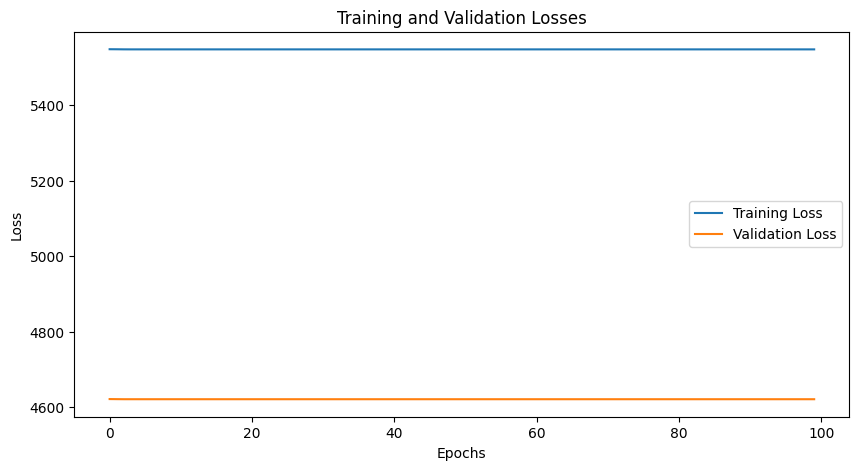

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for images in test_loader:
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)

        y_pred = model(img)
        loss = criterion(y_pred, std_map)
        test_loss += loss.item() * img.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 6925.5547


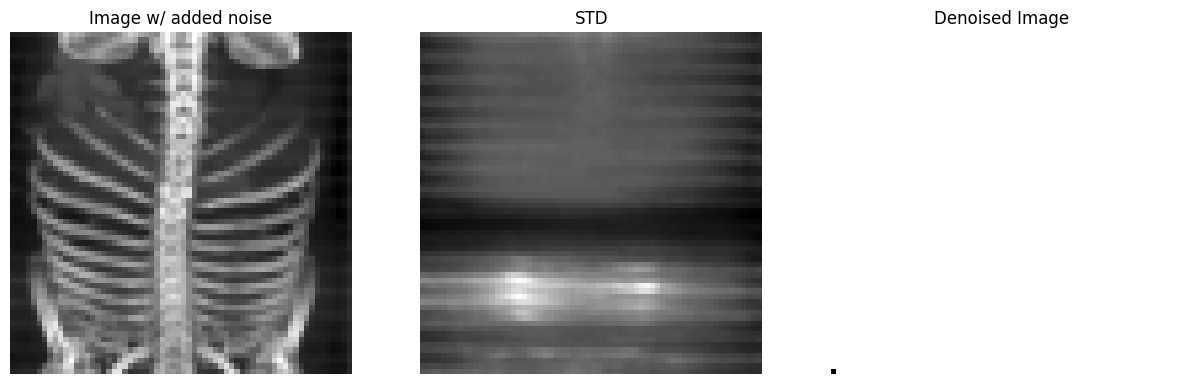

In [26]:
# model in evaluation mode
model.eval()

# get a batch from the test dataset
test_iter = iter(test_loader)
images = next(test_iter)

noisy_image = images['ct_generated'].float() 
std_image = images['std_map'].float() 

# select the first image in the batch
noisy_image_single = noisy_image[0].unsqueeze(0).to(device)  
std_image_single = std_image[0].to(device)

# Pass the noisy image through the model
with torch.no_grad():
    denoised_image = model(noisy_image_single)

# Move images back to CPU for visualization
noisy_image_cpu = noisy_image_single.squeeze(0).cpu() 
denoised_image_cpu = denoised_image.squeeze(0).cpu()
std_image_cpu = std_image_single.cpu()

# Plotting the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(noisy_image_cpu[0], cmap='gray') 
plt.title('Image w/ added noise')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(std_image_cpu[0], cmap='gray')  
plt.title('STD')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image_cpu[0], cmap='gray') 
plt.title('Denoised Image')
plt.axis('off')


plt.show()
# use fourier domain for denoising

# Section-5: Simulating a preliminary UNet

In [18]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_op = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.conv_op(x)
    
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self,x):
        down = self.conv(x)
        p = self.pool(down)
        
        return down, p
    
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x1,x2],1)
        
        return self.conv(x)   

In [19]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.down_convolution1 = DownSample(in_channels, 64)
        self.down_convolution2 = DownSample(64, 128)
        self.down_convolution3 = DownSample(128, 256)
        self.down_convolution4 = DownSample(256, 512)
        
        self.bottleneck = DoubleConv(512, 1024)
        
        self.up_convolution1 = UpSample(1024, 512)
        self.up_convolution2 = UpSample(512, 256)
        self.up_convolution3 = UpSample(256, 128)
        self.up_convolution4 = UpSample(128, 64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)
        
        
    def forward(self, x):
        down1, p1 = self.down_convolution1(x)
        down2, p2 = self.down_convolution2(p1)
        down3, p3 = self.down_convolution3(p2)
        down4, p4 = self.down_convolution4(p3)
        
        b = self.bottleneck(p4)
        
        up1 = self.up_convolution1(b, down4)
        up2 = self.up_convolution2(up1, down3)
        up3 = self.up_convolution3(up2, down2)
        up4 = self.up_convolution4(up3, down1)
        
        out = self.out(up4)
        
        return out
        

In [27]:
# initializing the model and optimizer

device = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet(in_channels = 1, num_classes = 1).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.0001)
model_saving_path = '/projectnb/ec500kb/projects/Project6/'

In [28]:
# initializing the loss function

#criterion = nn.MSELoss()
# Average Relative Error loss function
def average_relative_error(output, target):
    # Avoid division by zero
    nonzero_mask = target != 0
    return torch.mean(torch.abs((output[nonzero_mask] - target[nonzero_mask]) / target[nonzero_mask]))


In [24]:
# training loop

num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0
    for idx, images in enumerate(tqdm(train_loader)):
        
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        y_pred = model(img)
        optimizer.zero_grad()
        #########################
        loss = criterion(y_pred, std_map)
        running_loss += loss.item()
        ######################### change  += loss.item() * img.size(0)
        loss.backward()
        optimizer.step()
    
    train_loss = running_loss / idx+1
    
    
    model.eval()
    val_loss1 = 0
    running_val_loss = 0

    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            ######################### val_loss1 should = not +=
            val_loss1 += criterion(y_pred, std_map)
            running_val_loss += val_loss1.item()
            ######################### change += loss.item() * img.size(0)
        val_loss1 = running_val_loss / (idx + 1)
        
    print("-"*30)
    print(f"Train loss EPOCH {epoch+1}: {train_loss: .4f}")
    print(f"Validation loss EPOCH {epoch+1}: {val_loss1: .4f}")
    print("-"*30)


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]

  1%|          | 1/100 [00:00<00:24,  4.06it/s]

------------------------------
Train loss EPOCH 1:  6.0052
Validation loss EPOCH 1:  0.7113
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

  2%|▏         | 2/100 [00:00<00:23,  4.15it/s]

------------------------------
Train loss EPOCH 2:  4.9490
Validation loss EPOCH 2:  0.9265
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

  3%|▎         | 3/100 [00:00<00:23,  4.16it/s]

------------------------------
Train loss EPOCH 3:  3.8945
Validation loss EPOCH 3:  0.3728
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.60it/s]

  4%|▍         | 4/100 [00:00<00:23,  4.15it/s]

------------------------------
Train loss EPOCH 4:  4.1762
Validation loss EPOCH 4:  0.2676
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

  5%|▌         | 5/100 [00:01<00:23,  4.10it/s]

------------------------------
Train loss EPOCH 5:  4.7243
Validation loss EPOCH 5:  0.2874
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

  6%|▌         | 6/100 [00:01<00:22,  4.09it/s]

------------------------------
Train loss EPOCH 6:  4.3019
Validation loss EPOCH 6:  0.4623
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.81it/s]

  7%|▋         | 7/100 [00:01<00:22,  4.14it/s]

------------------------------
Train loss EPOCH 7:  3.9404
Validation loss EPOCH 7:  0.8127
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

  8%|▊         | 8/100 [00:01<00:22,  4.17it/s]

------------------------------
Train loss EPOCH 8:  4.3011
Validation loss EPOCH 8:  0.8459
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

  9%|▉         | 9/100 [00:02<00:21,  4.17it/s]

------------------------------
Train loss EPOCH 9:  4.1383
Validation loss EPOCH 9:  0.5711
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

 10%|█         | 10/100 [00:02<00:21,  4.12it/s]

------------------------------
Train loss EPOCH 10:  3.8665
Validation loss EPOCH 10:  0.4072
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

 11%|█         | 11/100 [00:02<00:21,  4.13it/s]

------------------------------
Train loss EPOCH 11:  3.9041
Validation loss EPOCH 11:  0.3774
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

 12%|█▏        | 12/100 [00:02<00:21,  4.16it/s]

------------------------------
Train loss EPOCH 12:  3.9430
Validation loss EPOCH 12:  0.4250
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

 13%|█▎        | 13/100 [00:03<00:21,  4.14it/s]

------------------------------
Train loss EPOCH 13:  3.8284
Validation loss EPOCH 13:  0.5434
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

 14%|█▍        | 14/100 [00:03<00:20,  4.12it/s]

------------------------------
Train loss EPOCH 14:  3.8338
Validation loss EPOCH 14:  0.6251
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.71it/s]

 15%|█▌        | 15/100 [00:03<00:20,  4.14it/s]

------------------------------
Train loss EPOCH 15:  3.8137
Validation loss EPOCH 15:  0.5611
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.63it/s]

 16%|█▌        | 16/100 [00:03<00:20,  4.14it/s]

------------------------------
Train loss EPOCH 16:  3.7344
Validation loss EPOCH 16:  0.4690
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

 17%|█▋        | 17/100 [00:04<00:20,  4.12it/s]

------------------------------
Train loss EPOCH 17:  3.7687
Validation loss EPOCH 17:  0.4043
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

 18%|█▊        | 18/100 [00:04<00:20,  4.07it/s]

------------------------------
Train loss EPOCH 18:  3.8404
Validation loss EPOCH 18:  0.4184
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

 19%|█▉        | 19/100 [00:04<00:20,  4.04it/s]

------------------------------
Train loss EPOCH 19:  3.7901
Validation loss EPOCH 19:  0.5036
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.97it/s]

 20%|██        | 20/100 [00:04<00:20,  3.98it/s]

------------------------------
Train loss EPOCH 20:  3.7075
Validation loss EPOCH 20:  0.6056
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.87it/s]

 21%|██        | 21/100 [00:05<00:20,  3.92it/s]

------------------------------
Train loss EPOCH 21:  3.9486
Validation loss EPOCH 21:  0.6243
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.16it/s]

 22%|██▏       | 22/100 [00:05<00:19,  3.92it/s]

------------------------------
Train loss EPOCH 22:  3.7798
Validation loss EPOCH 22:  0.4597
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.48it/s]

 23%|██▎       | 23/100 [00:05<00:19,  3.97it/s]

------------------------------
Train loss EPOCH 23:  3.7223
Validation loss EPOCH 23:  0.4104
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.35it/s]

 24%|██▍       | 24/100 [00:05<00:19,  3.98it/s]

------------------------------
Train loss EPOCH 24:  3.7792
Validation loss EPOCH 24:  0.4274
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.39it/s]

 25%|██▌       | 25/100 [00:06<00:18,  4.00it/s]

------------------------------
Train loss EPOCH 25:  3.7211
Validation loss EPOCH 25:  0.5162
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

 26%|██▌       | 26/100 [00:06<00:18,  3.97it/s]

------------------------------
Train loss EPOCH 26:  3.7215
Validation loss EPOCH 26:  0.6111
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.34it/s]

 27%|██▋       | 27/100 [00:06<00:18,  3.98it/s]

------------------------------
Train loss EPOCH 27:  3.7186
Validation loss EPOCH 27:  0.5693
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.09it/s]

 28%|██▊       | 28/100 [00:06<00:18,  3.95it/s]

------------------------------
Train loss EPOCH 28:  3.6652
Validation loss EPOCH 28:  0.5205
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.56it/s]

 29%|██▉       | 29/100 [00:07<00:17,  4.00it/s]

------------------------------
Train loss EPOCH 29:  3.7287
Validation loss EPOCH 29:  0.4569
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.63it/s]

 30%|███       | 30/100 [00:07<00:17,  4.04it/s]

------------------------------
Train loss EPOCH 30:  3.6544
Validation loss EPOCH 30:  0.4921
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

 31%|███       | 31/100 [00:07<00:16,  4.07it/s]

------------------------------
Train loss EPOCH 31:  3.6515
Validation loss EPOCH 31:  0.5638
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

 32%|███▏      | 32/100 [00:07<00:16,  4.11it/s]

------------------------------
Train loss EPOCH 32:  3.6223
Validation loss EPOCH 32:  0.5425
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

 33%|███▎      | 33/100 [00:08<00:16,  4.11it/s]

------------------------------
Train loss EPOCH 33:  3.6041
Validation loss EPOCH 33:  0.5097
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.19it/s]

 34%|███▍      | 34/100 [00:08<00:16,  4.06it/s]

------------------------------
Train loss EPOCH 34:  3.6100
Validation loss EPOCH 34:  0.4509
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.96it/s]

 35%|███▌      | 35/100 [00:08<00:16,  3.99it/s]

------------------------------
Train loss EPOCH 35:  3.5823
Validation loss EPOCH 35:  0.4846
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.58it/s]

 36%|███▌      | 36/100 [00:08<00:16,  3.88it/s]

------------------------------
Train loss EPOCH 36:  3.5287
Validation loss EPOCH 36:  0.5759
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.17it/s]

 37%|███▋      | 37/100 [00:09<00:16,  3.90it/s]

------------------------------
Train loss EPOCH 37:  3.5537
Validation loss EPOCH 37:  0.5654
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

 38%|███▊      | 38/100 [00:09<00:15,  3.98it/s]

------------------------------
Train loss EPOCH 38:  3.5623
Validation loss EPOCH 38:  0.4670
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.31it/s]

 39%|███▉      | 39/100 [00:09<00:15,  3.99it/s]

------------------------------
Train loss EPOCH 39:  3.4987
Validation loss EPOCH 39:  0.4723
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.83it/s]

 40%|████      | 40/100 [00:09<00:14,  4.06it/s]

------------------------------
Train loss EPOCH 40:  3.4681
Validation loss EPOCH 40:  0.5480
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.19it/s]

 41%|████      | 41/100 [00:10<00:14,  4.02it/s]

------------------------------
Train loss EPOCH 41:  3.4482
Validation loss EPOCH 41:  0.6031
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.33it/s]

 42%|████▏     | 42/100 [00:10<00:14,  4.02it/s]

------------------------------
Train loss EPOCH 42:  3.4726
Validation loss EPOCH 42:  0.4550
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.45it/s]

 43%|████▎     | 43/100 [00:10<00:14,  4.03it/s]

------------------------------
Train loss EPOCH 43:  3.4766
Validation loss EPOCH 43:  0.3620
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.02it/s]

 44%|████▍     | 44/100 [00:10<00:14,  3.98it/s]

------------------------------
Train loss EPOCH 44:  3.5247
Validation loss EPOCH 44:  0.4439
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.57it/s]

 45%|████▌     | 45/100 [00:11<00:14,  3.88it/s]

------------------------------
Train loss EPOCH 45:  3.4183
Validation loss EPOCH 45:  0.5607
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.14it/s]

 46%|████▌     | 46/100 [00:11<00:13,  3.89it/s]

------------------------------
Train loss EPOCH 46:  3.3446
Validation loss EPOCH 46:  0.4819
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.06it/s]

 47%|████▋     | 47/100 [00:11<00:14,  3.73it/s]

------------------------------
Train loss EPOCH 47:  3.2824
Validation loss EPOCH 47:  0.4225
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.52it/s]

 48%|████▊     | 48/100 [00:11<00:13,  3.84it/s]

------------------------------
Train loss EPOCH 48:  3.2681
Validation loss EPOCH 48:  0.4609
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

 49%|████▉     | 49/100 [00:12<00:13,  3.92it/s]

------------------------------
Train loss EPOCH 49:  3.2190
Validation loss EPOCH 49:  0.4843
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.17it/s]

 50%|█████     | 50/100 [00:12<00:12,  3.93it/s]

------------------------------
Train loss EPOCH 50:  3.2028
Validation loss EPOCH 50:  0.3967
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

 51%|█████     | 51/100 [00:12<00:12,  3.99it/s]

------------------------------
Train loss EPOCH 51:  3.1481
Validation loss EPOCH 51:  0.3927
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.29it/s]

 52%|█████▏    | 52/100 [00:12<00:12,  3.99it/s]

------------------------------
Train loss EPOCH 52:  3.0394
Validation loss EPOCH 52:  0.6506
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.70it/s]

 53%|█████▎    | 53/100 [00:13<00:11,  4.04it/s]

------------------------------
Train loss EPOCH 53:  3.2959
Validation loss EPOCH 53:  0.2870
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.50it/s]

 54%|█████▍    | 54/100 [00:13<00:11,  4.06it/s]

------------------------------
Train loss EPOCH 54:  3.3549
Validation loss EPOCH 54:  0.3677
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.39it/s]

 55%|█████▌    | 55/100 [00:13<00:11,  3.90it/s]

------------------------------
Train loss EPOCH 55:  3.2953
Validation loss EPOCH 55:  0.4213
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.96it/s]

 56%|█████▌    | 56/100 [00:13<00:11,  3.88it/s]

------------------------------
Train loss EPOCH 56:  2.9806
Validation loss EPOCH 56:  0.3246
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.53it/s]

 57%|█████▋    | 57/100 [00:14<00:10,  3.95it/s]

------------------------------
Train loss EPOCH 57:  3.1382
Validation loss EPOCH 57:  0.4517
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.04it/s]

 58%|█████▊    | 58/100 [00:14<00:10,  3.93it/s]

------------------------------
Train loss EPOCH 58:  3.0051
Validation loss EPOCH 58:  0.5506
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.31it/s]

 59%|█████▉    | 59/100 [00:14<00:10,  3.95it/s]

------------------------------
Train loss EPOCH 59:  3.1896
Validation loss EPOCH 59:  0.3893
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.06it/s]

 60%|██████    | 60/100 [00:14<00:10,  3.93it/s]

------------------------------
Train loss EPOCH 60:  3.0010
Validation loss EPOCH 60:  0.4060
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.30it/s]

 61%|██████    | 61/100 [00:15<00:09,  3.95it/s]

------------------------------
Train loss EPOCH 61:  2.9442
Validation loss EPOCH 61:  0.4737
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

 62%|██████▏   | 62/100 [00:15<00:09,  3.96it/s]

------------------------------
Train loss EPOCH 62:  3.0370
Validation loss EPOCH 62:  0.3775
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.27it/s]

 63%|██████▎   | 63/100 [00:15<00:09,  3.97it/s]

------------------------------
Train loss EPOCH 63:  2.9241
Validation loss EPOCH 63:  0.4124
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.69it/s]

 64%|██████▍   | 64/100 [00:15<00:08,  4.03it/s]

------------------------------
Train loss EPOCH 64:  2.9307
Validation loss EPOCH 64:  0.4325
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.67it/s]

 65%|██████▌   | 65/100 [00:16<00:08,  4.07it/s]

------------------------------
Train loss EPOCH 65:  2.9609
Validation loss EPOCH 65:  0.3404
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

 66%|██████▌   | 66/100 [00:16<00:08,  4.08it/s]

------------------------------
Train loss EPOCH 66:  2.8902
Validation loss EPOCH 66:  0.4348
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.44it/s]

 67%|██████▋   | 67/100 [00:16<00:08,  4.07it/s]

------------------------------
Train loss EPOCH 67:  3.0570
Validation loss EPOCH 67:  0.3710
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.71it/s]

 68%|██████▊   | 68/100 [00:16<00:08,  3.96it/s]

------------------------------
Train loss EPOCH 68:  2.8346
Validation loss EPOCH 68:  0.4646
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.00it/s]

 69%|██████▉   | 69/100 [00:17<00:07,  3.93it/s]

------------------------------
Train loss EPOCH 69:  3.1096
Validation loss EPOCH 69:  0.3258
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.96it/s]

 70%|███████   | 70/100 [00:17<00:07,  3.90it/s]

------------------------------
Train loss EPOCH 70:  2.8209
Validation loss EPOCH 70:  0.4335
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.84it/s]

 71%|███████   | 71/100 [00:17<00:07,  3.86it/s]

------------------------------
Train loss EPOCH 71:  2.8119
Validation loss EPOCH 71:  0.3310
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.29it/s]

 72%|███████▏  | 72/100 [00:17<00:07,  3.90it/s]

------------------------------
Train loss EPOCH 72:  2.7808
Validation loss EPOCH 72:  0.3948
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

 73%|███████▎  | 73/100 [00:18<00:06,  3.92it/s]

------------------------------
Train loss EPOCH 73:  2.8705
Validation loss EPOCH 73:  0.3948
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.29it/s]

 74%|███████▍  | 74/100 [00:18<00:06,  3.94it/s]

------------------------------
Train loss EPOCH 74:  2.8426
Validation loss EPOCH 74:  0.3040
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.54it/s]

 75%|███████▌  | 75/100 [00:18<00:06,  3.99it/s]

------------------------------
Train loss EPOCH 75:  2.8808
Validation loss EPOCH 75:  0.3029
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.36it/s]

 76%|███████▌  | 76/100 [00:18<00:05,  4.00it/s]

------------------------------
Train loss EPOCH 76:  2.9174
Validation loss EPOCH 76:  0.4774
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.90it/s]

 77%|███████▋  | 77/100 [00:19<00:05,  3.94it/s]

------------------------------
Train loss EPOCH 77:  2.7239
Validation loss EPOCH 77:  0.2804
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.98it/s]

 78%|███████▊  | 78/100 [00:19<00:05,  3.91it/s]

------------------------------
Train loss EPOCH 78:  2.8299
Validation loss EPOCH 78:  0.4325
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.16it/s]

 79%|███████▉  | 79/100 [00:19<00:05,  3.92it/s]

------------------------------
Train loss EPOCH 79:  2.7052
Validation loss EPOCH 79:  0.4459
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.70it/s]

 80%|████████  | 80/100 [00:20<00:05,  3.99it/s]

------------------------------
Train loss EPOCH 80:  2.6805
Validation loss EPOCH 80:  0.2565
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.47it/s]

 81%|████████  | 81/100 [00:20<00:04,  4.02it/s]

------------------------------
Train loss EPOCH 81:  2.9703
Validation loss EPOCH 81:  0.3337
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

 82%|████████▏ | 82/100 [00:20<00:04,  4.02it/s]

------------------------------
Train loss EPOCH 82:  2.5258
Validation loss EPOCH 82:  0.6146
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

 83%|████████▎ | 83/100 [00:20<00:04,  4.05it/s]

------------------------------
Train loss EPOCH 83:  2.9786
Validation loss EPOCH 83:  0.2197
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.12it/s]

 84%|████████▍ | 84/100 [00:20<00:03,  4.01it/s]

------------------------------
Train loss EPOCH 84:  3.2885
Validation loss EPOCH 84:  0.2802
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

 85%|████████▌ | 85/100 [00:21<00:03,  4.05it/s]

------------------------------
Train loss EPOCH 85:  2.8155
Validation loss EPOCH 85:  0.6538
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.84it/s]

 86%|████████▌ | 86/100 [00:21<00:03,  4.11it/s]

------------------------------
Train loss EPOCH 86:  3.2765
Validation loss EPOCH 86:  0.3042
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.22it/s]

 87%|████████▋ | 87/100 [00:21<00:03,  4.06it/s]

------------------------------
Train loss EPOCH 87:  3.0763
Validation loss EPOCH 87:  0.2339
------------------------------



100%|██████████| 2/2 [00:00<00:00,  7.67it/s]

 88%|████████▊ | 88/100 [00:21<00:03,  3.95it/s]

------------------------------
Train loss EPOCH 88:  3.2996
Validation loss EPOCH 88:  0.4343
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.68it/s]

 89%|████████▉ | 89/100 [00:22<00:02,  4.01it/s]

------------------------------
Train loss EPOCH 89:  3.2682
Validation loss EPOCH 89:  0.5765
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.59it/s]

 90%|█████████ | 90/100 [00:22<00:02,  4.05it/s]

------------------------------
Train loss EPOCH 90:  3.0045
Validation loss EPOCH 90:  0.3240
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.81it/s]

 91%|█████████ | 91/100 [00:22<00:02,  4.10it/s]

------------------------------
Train loss EPOCH 91:  2.9622
Validation loss EPOCH 91:  0.3402
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.75it/s]

 92%|█████████▏| 92/100 [00:22<00:01,  4.13it/s]

------------------------------
Train loss EPOCH 92:  2.9027
Validation loss EPOCH 92:  0.4560
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

 93%|█████████▎| 93/100 [00:23<00:01,  4.13it/s]

------------------------------
Train loss EPOCH 93:  2.7715
Validation loss EPOCH 93:  0.4250
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.76it/s]

 94%|█████████▍| 94/100 [00:23<00:01,  4.15it/s]

------------------------------
Train loss EPOCH 94:  2.7172
Validation loss EPOCH 94:  0.3156
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.61it/s]

 95%|█████████▌| 95/100 [00:23<00:01,  4.15it/s]

------------------------------
Train loss EPOCH 95:  2.7745
Validation loss EPOCH 95:  0.2855
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.43it/s]

 96%|█████████▌| 96/100 [00:23<00:00,  4.12it/s]

------------------------------
Train loss EPOCH 96:  2.7162
Validation loss EPOCH 96:  0.3892
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

 97%|█████████▋| 97/100 [00:24<00:00,  4.13it/s]

------------------------------
Train loss EPOCH 97:  2.6918
Validation loss EPOCH 97:  0.2883
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.60it/s]

 98%|█████████▊| 98/100 [00:24<00:00,  4.14it/s]

------------------------------
Train loss EPOCH 98:  2.6078
Validation loss EPOCH 98:  0.2899
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.58it/s]

 99%|█████████▉| 99/100 [00:24<00:00,  4.13it/s]

------------------------------
Train loss EPOCH 99:  2.5873
Validation loss EPOCH 99:  0.3411
------------------------------



100%|██████████| 2/2 [00:00<00:00,  8.55it/s]

100%|██████████| 100/100 [00:24<00:00,  4.02it/s]

------------------------------
Train loss EPOCH 100:  2.5138
Validation loss EPOCH 100:  0.3355
------------------------------


In [29]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        optimizer.zero_grad()
        y_pred = model(img)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


100%|██████████| 1/1 [00:00<00:00, 204.50it/s]


Epoch [1/100], Train Loss: 0.9987, Validation Loss: 0.9950


100%|██████████| 1/1 [00:00<00:00, 201.24it/s]


Epoch [2/100], Train Loss: 0.9969, Validation Loss: 0.9913


100%|██████████| 1/1 [00:00<00:00, 203.40it/s]


Epoch [3/100], Train Loss: 0.9945, Validation Loss: 0.9862


100%|██████████| 1/1 [00:00<00:00, 205.95it/s]


Epoch [4/100], Train Loss: 0.9916, Validation Loss: 0.9791


100%|██████████| 1/1 [00:00<00:00, 200.47it/s]


Epoch [5/100], Train Loss: 0.9872, Validation Loss: 0.9689


100%|██████████| 1/1 [00:00<00:00, 208.70it/s]


Epoch [6/100], Train Loss: 0.9811, Validation Loss: 0.9540


100%|██████████| 1/1 [00:00<00:00, 202.88it/s]


Epoch [7/100], Train Loss: 0.9718, Validation Loss: 0.9315


100%|██████████| 1/1 [00:00<00:00, 205.88it/s]


Epoch [8/100], Train Loss: 0.9575, Validation Loss: 0.8949


100%|██████████| 1/1 [00:00<00:00, 197.13it/s]


Epoch [9/100], Train Loss: 0.9353, Validation Loss: 0.8279


100%|██████████| 1/1 [00:00<00:00, 196.48it/s]


Epoch [10/100], Train Loss: 0.8903, Validation Loss: 0.6868


100%|██████████| 1/1 [00:00<00:00, 203.57it/s]


Epoch [11/100], Train Loss: 0.7931, Validation Loss: 0.3248


100%|██████████| 1/1 [00:00<00:00, 204.27it/s]


Epoch [12/100], Train Loss: 0.5161, Validation Loss: 1.1614


100%|██████████| 1/1 [00:00<00:00, 203.51it/s]


Epoch [13/100], Train Loss: 0.4885, Validation Loss: 0.6002


100%|██████████| 1/1 [00:00<00:00, 201.64it/s]


Epoch [14/100], Train Loss: 0.3376, Validation Loss: 0.3243


100%|██████████| 1/1 [00:00<00:00, 200.64it/s]


Epoch [15/100], Train Loss: 0.4072, Validation Loss: 0.3105


100%|██████████| 1/1 [00:00<00:00, 199.72it/s]


Epoch [16/100], Train Loss: 0.3987, Validation Loss: 0.4427


100%|██████████| 1/1 [00:00<00:00, 197.94it/s]


Epoch [17/100], Train Loss: 0.3616, Validation Loss: 0.7211


100%|██████████| 1/1 [00:00<00:00, 195.16it/s]


Epoch [18/100], Train Loss: 0.3725, Validation Loss: 0.7444


100%|██████████| 1/1 [00:00<00:00, 199.57it/s]


Epoch [19/100], Train Loss: 0.3729, Validation Loss: 0.6478


100%|██████████| 1/1 [00:00<00:00, 198.79it/s]


Epoch [20/100], Train Loss: 0.3508, Validation Loss: 0.5026


100%|██████████| 1/1 [00:00<00:00, 200.80it/s]


Epoch [21/100], Train Loss: 0.3440, Validation Loss: 0.4022


100%|██████████| 1/1 [00:00<00:00, 192.71it/s]


Epoch [22/100], Train Loss: 0.3642, Validation Loss: 0.3900


100%|██████████| 1/1 [00:00<00:00, 202.40it/s]


Epoch [23/100], Train Loss: 0.3539, Validation Loss: 0.5216


100%|██████████| 1/1 [00:00<00:00, 199.51it/s]


Epoch [24/100], Train Loss: 0.3525, Validation Loss: 0.6799


100%|██████████| 1/1 [00:00<00:00, 206.05it/s]


Epoch [25/100], Train Loss: 0.3564, Validation Loss: 0.5854


100%|██████████| 1/1 [00:00<00:00, 197.59it/s]


Epoch [26/100], Train Loss: 0.3479, Validation Loss: 0.4671


100%|██████████| 1/1 [00:00<00:00, 197.21it/s]


Epoch [27/100], Train Loss: 0.3432, Validation Loss: 0.4510


100%|██████████| 1/1 [00:00<00:00, 160.59it/s]


Epoch [28/100], Train Loss: 0.3423, Validation Loss: 0.5079


100%|██████████| 1/1 [00:00<00:00, 204.60it/s]


Epoch [29/100], Train Loss: 0.3389, Validation Loss: 0.5315


100%|██████████| 1/1 [00:00<00:00, 184.68it/s]


Epoch [30/100], Train Loss: 0.3456, Validation Loss: 0.4805


100%|██████████| 1/1 [00:00<00:00, 196.64it/s]


Epoch [31/100], Train Loss: 0.3354, Validation Loss: 0.5224


100%|██████████| 1/1 [00:00<00:00, 198.95it/s]


Epoch [32/100], Train Loss: 0.3325, Validation Loss: 0.5271


100%|██████████| 1/1 [00:00<00:00, 199.98it/s]


Epoch [33/100], Train Loss: 0.3310, Validation Loss: 0.4984


100%|██████████| 1/1 [00:00<00:00, 200.09it/s]


Epoch [34/100], Train Loss: 0.3347, Validation Loss: 0.4959


100%|██████████| 1/1 [00:00<00:00, 201.98it/s]


Epoch [35/100], Train Loss: 0.3244, Validation Loss: 0.5850


100%|██████████| 1/1 [00:00<00:00, 204.29it/s]


Epoch [36/100], Train Loss: 0.3405, Validation Loss: 0.5759


100%|██████████| 1/1 [00:00<00:00, 198.09it/s]


Epoch [37/100], Train Loss: 0.3197, Validation Loss: 0.4332


100%|██████████| 1/1 [00:00<00:00, 204.62it/s]


Epoch [38/100], Train Loss: 0.3298, Validation Loss: 0.3823


100%|██████████| 1/1 [00:00<00:00, 197.95it/s]


Epoch [39/100], Train Loss: 0.3332, Validation Loss: 0.4586


100%|██████████| 1/1 [00:00<00:00, 205.02it/s]


Epoch [40/100], Train Loss: 0.3240, Validation Loss: 0.6088


100%|██████████| 1/1 [00:00<00:00, 199.50it/s]


Epoch [41/100], Train Loss: 0.3233, Validation Loss: 0.5732


100%|██████████| 1/1 [00:00<00:00, 199.38it/s]


Epoch [42/100], Train Loss: 0.3152, Validation Loss: 0.4992


100%|██████████| 1/1 [00:00<00:00, 203.54it/s]


Epoch [43/100], Train Loss: 0.3121, Validation Loss: 0.4415


100%|██████████| 1/1 [00:00<00:00, 196.16it/s]


Epoch [44/100], Train Loss: 0.3114, Validation Loss: 0.4744


100%|██████████| 1/1 [00:00<00:00, 203.08it/s]


Epoch [45/100], Train Loss: 0.3038, Validation Loss: 0.5064


100%|██████████| 1/1 [00:00<00:00, 201.73it/s]


Epoch [46/100], Train Loss: 0.3048, Validation Loss: 0.5086


100%|██████████| 1/1 [00:00<00:00, 200.49it/s]


Epoch [47/100], Train Loss: 0.2930, Validation Loss: 0.4020


100%|██████████| 1/1 [00:00<00:00, 202.76it/s]


Epoch [48/100], Train Loss: 0.2987, Validation Loss: 0.4463


100%|██████████| 1/1 [00:00<00:00, 203.23it/s]


Epoch [49/100], Train Loss: 0.2977, Validation Loss: 0.5364


100%|██████████| 1/1 [00:00<00:00, 180.80it/s]


Epoch [50/100], Train Loss: 0.2787, Validation Loss: 0.3632


100%|██████████| 1/1 [00:00<00:00, 170.44it/s]


Epoch [51/100], Train Loss: 0.2912, Validation Loss: 0.4427


100%|██████████| 1/1 [00:00<00:00, 202.13it/s]


Epoch [52/100], Train Loss: 0.2714, Validation Loss: 0.5519


100%|██████████| 1/1 [00:00<00:00, 198.90it/s]


Epoch [53/100], Train Loss: 0.2850, Validation Loss: 0.3691


100%|██████████| 1/1 [00:00<00:00, 206.25it/s]


Epoch [54/100], Train Loss: 0.2712, Validation Loss: 0.5171


100%|██████████| 1/1 [00:00<00:00, 201.44it/s]


Epoch [55/100], Train Loss: 0.2712, Validation Loss: 0.5044


100%|██████████| 1/1 [00:00<00:00, 209.04it/s]


Epoch [56/100], Train Loss: 0.2635, Validation Loss: 0.3923


100%|██████████| 1/1 [00:00<00:00, 204.36it/s]


Epoch [57/100], Train Loss: 0.2599, Validation Loss: 0.4534


100%|██████████| 1/1 [00:00<00:00, 193.25it/s]


Epoch [58/100], Train Loss: 0.2641, Validation Loss: 0.3775


100%|██████████| 1/1 [00:00<00:00, 187.05it/s]


Epoch [59/100], Train Loss: 0.2662, Validation Loss: 0.3456


100%|██████████| 1/1 [00:00<00:00, 206.59it/s]


Epoch [60/100], Train Loss: 0.2391, Validation Loss: 0.8443


100%|██████████| 1/1 [00:00<00:00, 200.23it/s]


Epoch [61/100], Train Loss: 0.3563, Validation Loss: 0.2746


100%|██████████| 1/1 [00:00<00:00, 204.26it/s]


Epoch [62/100], Train Loss: 0.3129, Validation Loss: 0.2636


100%|██████████| 1/1 [00:00<00:00, 195.65it/s]


Epoch [63/100], Train Loss: 0.3032, Validation Loss: 0.5155


100%|██████████| 1/1 [00:00<00:00, 203.79it/s]


Epoch [64/100], Train Loss: 0.2807, Validation Loss: 0.6567


100%|██████████| 1/1 [00:00<00:00, 205.65it/s]


Epoch [65/100], Train Loss: 0.2970, Validation Loss: 0.3894


100%|██████████| 1/1 [00:00<00:00, 198.92it/s]


Epoch [66/100], Train Loss: 0.2737, Validation Loss: 0.3398


100%|██████████| 1/1 [00:00<00:00, 198.64it/s]


Epoch [67/100], Train Loss: 0.2740, Validation Loss: 0.4726


100%|██████████| 1/1 [00:00<00:00, 204.02it/s]


Epoch [68/100], Train Loss: 0.2575, Validation Loss: 0.5938


100%|██████████| 1/1 [00:00<00:00, 192.67it/s]


Epoch [69/100], Train Loss: 0.2732, Validation Loss: 0.4737


100%|██████████| 1/1 [00:00<00:00, 197.53it/s]


Epoch [70/100], Train Loss: 0.2604, Validation Loss: 0.3310


100%|██████████| 1/1 [00:00<00:00, 201.70it/s]


Epoch [71/100], Train Loss: 0.2641, Validation Loss: 0.4044


100%|██████████| 1/1 [00:00<00:00, 196.86it/s]


Epoch [72/100], Train Loss: 0.2573, Validation Loss: 0.4736


100%|██████████| 1/1 [00:00<00:00, 197.03it/s]


Epoch [73/100], Train Loss: 0.2447, Validation Loss: 0.3305


100%|██████████| 1/1 [00:00<00:00, 202.94it/s]


Epoch [74/100], Train Loss: 0.2573, Validation Loss: 0.3044


100%|██████████| 1/1 [00:00<00:00, 201.20it/s]


Epoch [75/100], Train Loss: 0.2554, Validation Loss: 0.4451


100%|██████████| 1/1 [00:00<00:00, 196.15it/s]


Epoch [76/100], Train Loss: 0.2439, Validation Loss: 0.4265


100%|██████████| 1/1 [00:00<00:00, 194.65it/s]


Epoch [77/100], Train Loss: 0.2470, Validation Loss: 0.3907


100%|██████████| 1/1 [00:00<00:00, 200.94it/s]


Epoch [78/100], Train Loss: 0.2341, Validation Loss: 0.4467


100%|██████████| 1/1 [00:00<00:00, 205.18it/s]


Epoch [79/100], Train Loss: 0.2376, Validation Loss: 0.3665


100%|██████████| 1/1 [00:00<00:00, 204.60it/s]


Epoch [80/100], Train Loss: 0.2341, Validation Loss: 0.3439


100%|██████████| 1/1 [00:00<00:00, 204.08it/s]


Epoch [81/100], Train Loss: 0.2322, Validation Loss: 0.4312


100%|██████████| 1/1 [00:00<00:00, 196.85it/s]


Epoch [82/100], Train Loss: 0.2394, Validation Loss: 0.3539


100%|██████████| 1/1 [00:00<00:00, 200.74it/s]


Epoch [83/100], Train Loss: 0.2320, Validation Loss: 0.3545


100%|██████████| 1/1 [00:00<00:00, 205.18it/s]


Epoch [84/100], Train Loss: 0.2282, Validation Loss: 0.3507


100%|██████████| 1/1 [00:00<00:00, 209.00it/s]


Epoch [85/100], Train Loss: 0.2243, Validation Loss: 0.4250


100%|██████████| 1/1 [00:00<00:00, 192.29it/s]


Epoch [86/100], Train Loss: 0.2262, Validation Loss: 0.3264


100%|██████████| 1/1 [00:00<00:00, 199.34it/s]


Epoch [87/100], Train Loss: 0.2260, Validation Loss: 0.3798


100%|██████████| 1/1 [00:00<00:00, 207.11it/s]


Epoch [88/100], Train Loss: 0.2256, Validation Loss: 0.3742


100%|██████████| 1/1 [00:00<00:00, 191.13it/s]


Epoch [89/100], Train Loss: 0.2196, Validation Loss: 0.3180


100%|██████████| 1/1 [00:00<00:00, 198.94it/s]


Epoch [90/100], Train Loss: 0.2152, Validation Loss: 0.4984


100%|██████████| 1/1 [00:00<00:00, 198.92it/s]


Epoch [91/100], Train Loss: 0.2356, Validation Loss: 0.2705


100%|██████████| 1/1 [00:00<00:00, 202.47it/s]


Epoch [92/100], Train Loss: 0.2305, Validation Loss: 0.3625


100%|██████████| 1/1 [00:00<00:00, 199.70it/s]


Epoch [93/100], Train Loss: 0.2116, Validation Loss: 0.4665


100%|██████████| 1/1 [00:00<00:00, 197.21it/s]


Epoch [94/100], Train Loss: 0.2269, Validation Loss: 0.2693


100%|██████████| 1/1 [00:00<00:00, 198.90it/s]


Epoch [95/100], Train Loss: 0.2241, Validation Loss: 0.4026


100%|██████████| 1/1 [00:00<00:00, 201.14it/s]


Epoch [96/100], Train Loss: 0.2216, Validation Loss: 0.2808


100%|██████████| 1/1 [00:00<00:00, 201.07it/s]


Epoch [97/100], Train Loss: 0.2312, Validation Loss: 0.3166


100%|██████████| 1/1 [00:00<00:00, 201.42it/s]


Epoch [98/100], Train Loss: 0.2176, Validation Loss: 0.4701


100%|██████████| 1/1 [00:00<00:00, 199.18it/s]


Epoch [99/100], Train Loss: 0.2138, Validation Loss: 0.2627


100%|██████████| 1/1 [00:00<00:00, 197.10it/s]

Epoch [100/100], Train Loss: 0.2244, Validation Loss: 0.3989


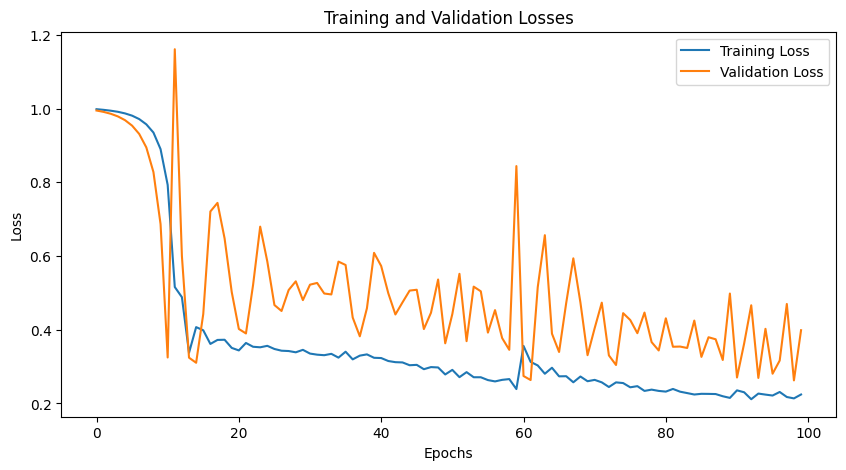

In [30]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [31]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for images in test_loader:
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)

        y_pred = model(img)
        loss = average_relative_error(y_pred, std_map)
        test_loss += loss.item() * img.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.4264


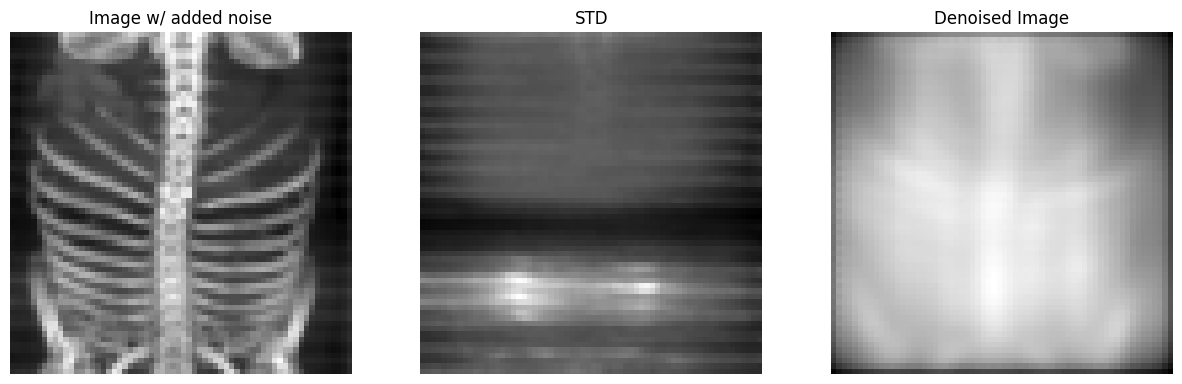

In [32]:
# model in evaluation mode
model.eval()

# get a batch from the test dataset
test_iter = iter(test_loader)
images = next(test_iter)

noisy_image = images['ct_generated'].float() 
std_image = images['std_map'].float() 

# select the first image in the batch
noisy_image_single = noisy_image[0].unsqueeze(0).to(device)  
std_image_single = std_image[0].to(device)

# Pass the noisy image through the model
with torch.no_grad():
    denoised_image = model(noisy_image_single)

# Move images back to CPU for visualization
noisy_image_cpu = noisy_image_single.squeeze(0).cpu() 
denoised_image_cpu = denoised_image.squeeze(0).cpu()
std_image_cpu = std_image_single.cpu()

# Plotting the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(noisy_image_cpu[0], cmap='gray') 
plt.title('Image w/ added noise')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(std_image_cpu[0], cmap='gray')  
plt.title('STD')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image_cpu[0], cmap='gray') 
plt.title('Denoised Image')
plt.axis('off')


plt.show()
# use fourier domain for denoising

# Section-6: Simulating a RatUNet (Residual UNet)

In [33]:
import os
import math

In [34]:
class RatUNet(nn.Module):
    def __init__(self, block, num_features=64):
        super(RatUNet, self).__init__()
        self.inplanes = num_features
        
        self.conv = nn.Conv2d(1, num_features, kernel_size=3, stride=1, padding=1, bias=True)

        self.layer1 = self._make_layer(block, 64, 128, 3, stride=2)
        self.layer2 = self._make_layer(block, 128, 256, 3, stride=2)

        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.layer3 = self._make_layer(block, 256, 512, 4, stride=2)
        self.deconv2 = nn.ConvTranspose2d(512, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)

        self.layer4 = self._make_layer(block, 256, 256, 3)
        self.layer5 = self._make_layer(block, 128, 128, 3)
        self.layer6 = self._make_layer(block, 128, 128, 2)
        self.conv2 = nn.Sequential(nn.Conv2d(192, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=True),
                                   nn.PReLU(),
                                   nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128, bias=True),
                                   nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0, bias=True),
                                   nn.ReLU(inplace=True),
                                   )
        self.ca = SequentialPolarizedSelfAttention(128)
        self.lastconv = nn.Conv2d(128, 1, kernel_size=3, stride=1, padding=1, bias=True)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0.0, math.sqrt(1.0 / n))
                m.bias.data.zero_()

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        layers = []
        downsample = None
        self.inplanes = inplanes
        if stride != 1:
            downsample = nn.Sequential(
                    nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
                    nn.AvgPool2d(kernel_size=2, stride=stride),
            )
#        if  stride == 1 and self.inplanes == 2*planes:
#            downsample = nn.Sequential(
#                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, bias=True),
#                #nn.BatchNorm2d(planes)
#            )
        
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        
        res = self.conv(x)

        res2 = self.layer1(res)
        res3 = self.layer2(res2)        
        out = self.layer3(res3)
        
        out = self.deconv1(out)               
        out = self.layer4(out)
        out = torch.cat((out, res3), dim=1) 

        out = self.deconv2(out)        
        out = self.layer5(out)
        out = torch.cat((out, res2), dim=1)
        
        out = self.deconv3(out)        
        out = self.layer6(out)
        out = torch.cat((out, res), dim=1)
        
        out = self.conv2(out)
        out = self.ca(out)
        out = self.lastconv(out)
        
        return x - out


In [35]:
class BasicBlock(nn.Module):
    expansion=1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=3, stride = stride, padding=1, bias=True)
        #self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.PReLU()#.LeakyReLU(0.2, inplace=True)# nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride = 1, padding=1, bias=True)
        #self.conv3 = nn.Conv2d(planes, planes, kernel_size=1, stride = 1, padding=0, bias=True)

        self.downsample = downsample
        #self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        #out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)        
        
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual      
        out = self.relu(out)

        return out


In [36]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // 16, 1, bias=True),
                               nn.ReLU(),
                               nn.Conv2d(in_planes // 16, in_planes, 1, bias=True))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
    
class SequentialPolarizedSelfAttention(nn.Module):

    def __init__(self, channel=512):
        super().__init__()
        self.ch_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.ch_wq=nn.Conv2d(channel,1,kernel_size=(1,1))
        self.softmax_channel=nn.Softmax(1)
        self.softmax_spatial=nn.Softmax(-1)
        self.ch_wz=nn.Conv2d(channel//2,channel,kernel_size=(1,1))
        self.ln=nn.LayerNorm(channel)
        self.sigmoid=nn.Sigmoid()
        self.sp_wv=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.sp_wq=nn.Conv2d(channel,channel//2,kernel_size=(1,1))
        self.agp=nn.AdaptiveAvgPool2d((1,1))

    def forward(self, x):
        b, c, h, w = x.size()

        #Channel-only Self-Attention
        channel_wv=self.ch_wv(x) #bs,c//2,h,w
        channel_wq=self.ch_wq(x) #bs,1,h,w
        channel_wv=channel_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        channel_wq=channel_wq.reshape(b,-1,1) #bs,h*w,1
        channel_wq=self.softmax_channel(channel_wq)
        channel_wz=torch.matmul(channel_wv,channel_wq).unsqueeze(-1) #bs,c//2,1,1
        channel_weight=self.sigmoid(self.ch_wz(channel_wz).reshape(b,c,1).permute(0,2,1)).permute(0,2,1).reshape(b,c,1,1) #bs,c,1,1self.ln(
        channel_out=channel_weight*x

        #Spatial-only Self-Attention
        spatial_wv=self.sp_wv(channel_out) #bs,c//2,h,w
        spatial_wq=self.sp_wq(channel_out) #bs,c//2,h,w
        spatial_wq=self.agp(spatial_wq) #bs,c//2,1,1
        spatial_wv=spatial_wv.reshape(b,c//2,-1) #bs,c//2,h*w
        spatial_wq=spatial_wq.permute(0,2,3,1).reshape(b,1,c//2) #bs,1,c//2
        spatial_wq=self.softmax_spatial(spatial_wq)
        spatial_wz=torch.matmul(spatial_wq,spatial_wv) #bs,1,h*w
        spatial_weight=self.sigmoid(spatial_wz.reshape(b,1,h,w)) #bs,1,h,w
        spatial_out=spatial_weight*channel_out
        return spatial_out


In [37]:
import torch.optim as optim
from tqdm import tqdm

# Average Relative Error loss function
def average_relative_error(output, target):
    # Avoid division by zero
    nonzero_mask = target != 0
    return torch.mean(torch.abs((output[nonzero_mask] - target[nonzero_mask]) / target[nonzero_mask]))

# Model and optimizer initialization
device = "cuda" if torch.cuda.is_available() else "cpu"
model = RatUNet(BasicBlock, 64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
#criterion = nn.MSELoss()
#criterion = nn.L1Loss()
model_saving_path = '/projectnb/ec500kb/projects/Project6/RatUNet.pth'

# Train the model
total_step = len(train_loader)
num_epochs = 300
best_val_loss = float('inf')  # Initialize best validation loss for model saving


In [38]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    model.train()  # Ensure the model is in training mode

    for idx, images in enumerate(tqdm(train_loader)):
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)
        
        optimizer.zero_grad()
        y_pred = model(img)
        loss = average_relative_error(y_pred, std_map)
        #loss = criterion(y_pred, std_map)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * img.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for idx, image in enumerate(tqdm(val_loader)):
            img = image['ct_generated'].float().to(device)
            std_map = image['std_map'].float().to(device)

            y_pred = model(img)
            val_loss = average_relative_error(y_pred, std_map)
            #val_loss = criterion(y_pred, std_map)
            running_val_loss += val_loss.item() * img.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")


100%|██████████| 1/1 [00:00<00:00, 22.32it/s]


Epoch [1/300], Train Loss: 0.8719, Validation Loss: 0.7594


100%|██████████| 1/1 [00:00<00:00, 102.76it/s]


Epoch [2/300], Train Loss: 0.8668, Validation Loss: 0.6984


100%|██████████| 1/1 [00:00<00:00, 99.46it/s]


Epoch [3/300], Train Loss: 0.7849, Validation Loss: 0.8882


100%|██████████| 1/1 [00:00<00:00, 102.69it/s]


Epoch [4/300], Train Loss: 0.4608, Validation Loss: 0.4876


100%|██████████| 1/1 [00:00<00:00, 101.66it/s]


Epoch [5/300], Train Loss: 0.7078, Validation Loss: 0.3536


100%|██████████| 1/1 [00:00<00:00, 100.29it/s]


Epoch [6/300], Train Loss: 0.6050, Validation Loss: 0.6999


100%|██████████| 1/1 [00:00<00:00, 100.69it/s]


Epoch [7/300], Train Loss: 0.4750, Validation Loss: 0.6505


100%|██████████| 1/1 [00:00<00:00, 102.49it/s]


Epoch [8/300], Train Loss: 0.4498, Validation Loss: 0.2859


100%|██████████| 1/1 [00:00<00:00, 101.94it/s]


Epoch [9/300], Train Loss: 0.5239, Validation Loss: 0.4330


100%|██████████| 1/1 [00:00<00:00, 99.55it/s]


Epoch [10/300], Train Loss: 0.4084, Validation Loss: 1.0367


100%|██████████| 1/1 [00:00<00:00, 100.74it/s]


Epoch [11/300], Train Loss: 0.4715, Validation Loss: 0.5351


100%|██████████| 1/1 [00:00<00:00, 101.39it/s]


Epoch [12/300], Train Loss: 0.5598, Validation Loss: 0.7531


100%|██████████| 1/1 [00:00<00:00, 103.16it/s]


Epoch [13/300], Train Loss: 0.7549, Validation Loss: 0.2990


100%|██████████| 1/1 [00:00<00:00, 101.67it/s]


Epoch [14/300], Train Loss: 0.5452, Validation Loss: 0.4824


100%|██████████| 1/1 [00:00<00:00, 101.41it/s]


Epoch [15/300], Train Loss: 0.4185, Validation Loss: 0.8702


100%|██████████| 1/1 [00:00<00:00, 102.57it/s]


Epoch [16/300], Train Loss: 0.4716, Validation Loss: 1.0116


100%|██████████| 1/1 [00:00<00:00, 102.35it/s]


Epoch [17/300], Train Loss: 0.4534, Validation Loss: 0.3187


100%|██████████| 1/1 [00:00<00:00, 102.47it/s]


Epoch [18/300], Train Loss: 0.4940, Validation Loss: 0.3019


100%|██████████| 1/1 [00:00<00:00, 104.02it/s]


Epoch [19/300], Train Loss: 0.4912, Validation Loss: 0.4875


100%|██████████| 1/1 [00:00<00:00, 99.32it/s]


Epoch [20/300], Train Loss: 0.4087, Validation Loss: 1.0065


100%|██████████| 1/1 [00:00<00:00, 101.04it/s]


Epoch [21/300], Train Loss: 0.4915, Validation Loss: 0.7123


100%|██████████| 1/1 [00:00<00:00, 100.49it/s]


Epoch [22/300], Train Loss: 0.4191, Validation Loss: 0.3139


100%|██████████| 1/1 [00:00<00:00, 101.30it/s]


Epoch [23/300], Train Loss: 0.4545, Validation Loss: 0.3295


100%|██████████| 1/1 [00:00<00:00, 98.29it/s]


Epoch [24/300], Train Loss: 0.4212, Validation Loss: 0.6167


100%|██████████| 1/1 [00:00<00:00, 85.47it/s]


Epoch [25/300], Train Loss: 0.3845, Validation Loss: 0.9369


100%|██████████| 1/1 [00:00<00:00, 86.51it/s]


Epoch [26/300], Train Loss: 0.4239, Validation Loss: 0.6420


100%|██████████| 1/1 [00:00<00:00, 102.04it/s]


Epoch [27/300], Train Loss: 0.3888, Validation Loss: 0.3527


100%|██████████| 1/1 [00:00<00:00, 100.20it/s]


Epoch [28/300], Train Loss: 0.4022, Validation Loss: 0.3556


100%|██████████| 1/1 [00:00<00:00, 103.07it/s]


Epoch [29/300], Train Loss: 0.3800, Validation Loss: 0.5534


100%|██████████| 1/1 [00:00<00:00, 101.44it/s]


Epoch [30/300], Train Loss: 0.3636, Validation Loss: 0.6831


100%|██████████| 1/1 [00:00<00:00, 102.86it/s]


Epoch [31/300], Train Loss: 0.3573, Validation Loss: 0.4806


100%|██████████| 1/1 [00:00<00:00, 102.51it/s]


Epoch [32/300], Train Loss: 0.3513, Validation Loss: 0.3310


100%|██████████| 1/1 [00:00<00:00, 99.77it/s]


Epoch [33/300], Train Loss: 0.3613, Validation Loss: 0.4011


100%|██████████| 1/1 [00:00<00:00, 100.25it/s]


Epoch [34/300], Train Loss: 0.3397, Validation Loss: 0.5339


100%|██████████| 1/1 [00:00<00:00, 102.60it/s]


Epoch [35/300], Train Loss: 0.3302, Validation Loss: 0.5108


100%|██████████| 1/1 [00:00<00:00, 102.72it/s]


Epoch [36/300], Train Loss: 0.3256, Validation Loss: 0.4707


100%|██████████| 1/1 [00:00<00:00, 99.21it/s]


Epoch [37/300], Train Loss: 0.3207, Validation Loss: 0.4497


100%|██████████| 1/1 [00:00<00:00, 100.61it/s]


Epoch [38/300], Train Loss: 0.3179, Validation Loss: 0.3991


100%|██████████| 1/1 [00:00<00:00, 100.83it/s]


Epoch [39/300], Train Loss: 0.3158, Validation Loss: 0.4878


100%|██████████| 1/1 [00:00<00:00, 100.25it/s]


Epoch [40/300], Train Loss: 0.3100, Validation Loss: 0.4037


100%|██████████| 1/1 [00:00<00:00, 101.39it/s]


Epoch [41/300], Train Loss: 0.3136, Validation Loss: 0.3962


100%|██████████| 1/1 [00:00<00:00, 104.38it/s]


Epoch [42/300], Train Loss: 0.3007, Validation Loss: 0.6854


100%|██████████| 1/1 [00:00<00:00, 101.75it/s]


Epoch [43/300], Train Loss: 0.3419, Validation Loss: 0.3998


100%|██████████| 1/1 [00:00<00:00, 100.79it/s]


Epoch [44/300], Train Loss: 0.3175, Validation Loss: 0.2648


100%|██████████| 1/1 [00:00<00:00, 102.37it/s]


Epoch [45/300], Train Loss: 0.3478, Validation Loss: 0.5048


100%|██████████| 1/1 [00:00<00:00, 103.75it/s]


Epoch [46/300], Train Loss: 0.3241, Validation Loss: 0.7050


100%|██████████| 1/1 [00:00<00:00, 103.05it/s]


Epoch [47/300], Train Loss: 0.3120, Validation Loss: 0.4048


100%|██████████| 1/1 [00:00<00:00, 104.42it/s]


Epoch [48/300], Train Loss: 0.3136, Validation Loss: 0.3085


100%|██████████| 1/1 [00:00<00:00, 102.42it/s]


Epoch [49/300], Train Loss: 0.3355, Validation Loss: 0.4320


100%|██████████| 1/1 [00:00<00:00, 101.96it/s]


Epoch [50/300], Train Loss: 0.3007, Validation Loss: 0.5533


100%|██████████| 1/1 [00:00<00:00, 102.28it/s]


Epoch [51/300], Train Loss: 0.2975, Validation Loss: 0.4817


100%|██████████| 1/1 [00:00<00:00, 102.30it/s]


Epoch [52/300], Train Loss: 0.2949, Validation Loss: 0.4781


100%|██████████| 1/1 [00:00<00:00, 98.27it/s]


Epoch [53/300], Train Loss: 0.2870, Validation Loss: 0.5357


100%|██████████| 1/1 [00:00<00:00, 100.77it/s]


Epoch [54/300], Train Loss: 0.2838, Validation Loss: 0.5053


100%|██████████| 1/1 [00:00<00:00, 100.66it/s]


Epoch [55/300], Train Loss: 0.2785, Validation Loss: 0.4205


100%|██████████| 1/1 [00:00<00:00, 103.43it/s]


Epoch [56/300], Train Loss: 0.2744, Validation Loss: 0.4335


100%|██████████| 1/1 [00:00<00:00, 102.30it/s]


Epoch [57/300], Train Loss: 0.2783, Validation Loss: 0.3718


100%|██████████| 1/1 [00:00<00:00, 100.57it/s]


Epoch [58/300], Train Loss: 0.2692, Validation Loss: 0.3978


100%|██████████| 1/1 [00:00<00:00, 100.94it/s]


Epoch [59/300], Train Loss: 0.2796, Validation Loss: 0.4399


100%|██████████| 1/1 [00:00<00:00, 102.86it/s]


Epoch [60/300], Train Loss: 0.2572, Validation Loss: 0.3632


100%|██████████| 1/1 [00:00<00:00, 102.29it/s]


Epoch [61/300], Train Loss: 0.2594, Validation Loss: 0.4957


100%|██████████| 1/1 [00:00<00:00, 101.58it/s]


Epoch [62/300], Train Loss: 0.2408, Validation Loss: 0.2476


100%|██████████| 1/1 [00:00<00:00, 99.95it/s]


Epoch [63/300], Train Loss: 0.3026, Validation Loss: 0.3850


100%|██████████| 1/1 [00:00<00:00, 100.64it/s]


Epoch [64/300], Train Loss: 0.2392, Validation Loss: 0.7909


100%|██████████| 1/1 [00:00<00:00, 105.42it/s]


Epoch [65/300], Train Loss: 0.3009, Validation Loss: 0.2038


100%|██████████| 1/1 [00:00<00:00, 102.69it/s]


Epoch [66/300], Train Loss: 0.3612, Validation Loss: 0.1966


100%|██████████| 1/1 [00:00<00:00, 103.40it/s]


Epoch [67/300], Train Loss: 0.3395, Validation Loss: 0.6088


100%|██████████| 1/1 [00:00<00:00, 103.66it/s]


Epoch [68/300], Train Loss: 0.3111, Validation Loss: 0.6261


100%|██████████| 1/1 [00:00<00:00, 97.27it/s]


Epoch [69/300], Train Loss: 0.2697, Validation Loss: 0.3215


100%|██████████| 1/1 [00:00<00:00, 103.74it/s]


Epoch [70/300], Train Loss: 0.2961, Validation Loss: 0.3611


100%|██████████| 1/1 [00:00<00:00, 98.04it/s]


Epoch [71/300], Train Loss: 0.2829, Validation Loss: 0.5736


100%|██████████| 1/1 [00:00<00:00, 100.33it/s]


Epoch [72/300], Train Loss: 0.3117, Validation Loss: 0.4722


100%|██████████| 1/1 [00:00<00:00, 102.20it/s]


Epoch [73/300], Train Loss: 0.2557, Validation Loss: 0.2958


100%|██████████| 1/1 [00:00<00:00, 98.51it/s]


Epoch [74/300], Train Loss: 0.2703, Validation Loss: 0.4956


100%|██████████| 1/1 [00:00<00:00, 102.74it/s]


Epoch [75/300], Train Loss: 0.2674, Validation Loss: 0.6075


100%|██████████| 1/1 [00:00<00:00, 103.33it/s]


Epoch [76/300], Train Loss: 0.2687, Validation Loss: 0.2939


100%|██████████| 1/1 [00:00<00:00, 102.00it/s]


Epoch [77/300], Train Loss: 0.2535, Validation Loss: 0.3954


100%|██████████| 1/1 [00:00<00:00, 103.22it/s]


Epoch [78/300], Train Loss: 0.2301, Validation Loss: 0.4725


100%|██████████| 1/1 [00:00<00:00, 100.34it/s]


Epoch [79/300], Train Loss: 0.2550, Validation Loss: 0.2739


100%|██████████| 1/1 [00:00<00:00, 100.89it/s]


Epoch [80/300], Train Loss: 0.2425, Validation Loss: 0.4703


100%|██████████| 1/1 [00:00<00:00, 104.32it/s]


Epoch [81/300], Train Loss: 0.2325, Validation Loss: 0.4705


100%|██████████| 1/1 [00:00<00:00, 101.91it/s]


Epoch [82/300], Train Loss: 0.2208, Validation Loss: 0.3213


100%|██████████| 1/1 [00:00<00:00, 102.79it/s]


Epoch [83/300], Train Loss: 0.2330, Validation Loss: 0.3672


100%|██████████| 1/1 [00:00<00:00, 103.56it/s]


Epoch [84/300], Train Loss: 0.2201, Validation Loss: 0.4898


100%|██████████| 1/1 [00:00<00:00, 100.46it/s]


Epoch [85/300], Train Loss: 0.2254, Validation Loss: 0.2803


100%|██████████| 1/1 [00:00<00:00, 101.15it/s]


Epoch [86/300], Train Loss: 0.2391, Validation Loss: 0.3065


100%|██████████| 1/1 [00:00<00:00, 100.21it/s]


Epoch [87/300], Train Loss: 0.2254, Validation Loss: 0.4212


100%|██████████| 1/1 [00:00<00:00, 100.46it/s]


Epoch [88/300], Train Loss: 0.2095, Validation Loss: 0.3073


100%|██████████| 1/1 [00:00<00:00, 94.31it/s]


Epoch [89/300], Train Loss: 0.2252, Validation Loss: 0.3623


100%|██████████| 1/1 [00:00<00:00, 98.73it/s]


Epoch [90/300], Train Loss: 0.2295, Validation Loss: 0.4106


100%|██████████| 1/1 [00:00<00:00, 103.74it/s]


Epoch [91/300], Train Loss: 0.2014, Validation Loss: 0.2674


100%|██████████| 1/1 [00:00<00:00, 98.65it/s]


Epoch [92/300], Train Loss: 0.2273, Validation Loss: 0.3737


100%|██████████| 1/1 [00:00<00:00, 104.20it/s]


Epoch [93/300], Train Loss: 0.2138, Validation Loss: 0.4174


100%|██████████| 1/1 [00:00<00:00, 99.84it/s]


Epoch [94/300], Train Loss: 0.2042, Validation Loss: 0.2612


100%|██████████| 1/1 [00:00<00:00, 101.99it/s]


Epoch [95/300], Train Loss: 0.2309, Validation Loss: 0.3427


100%|██████████| 1/1 [00:00<00:00, 102.20it/s]


Epoch [96/300], Train Loss: 0.2038, Validation Loss: 0.4995


100%|██████████| 1/1 [00:00<00:00, 101.18it/s]


Epoch [97/300], Train Loss: 0.2191, Validation Loss: 0.2830


100%|██████████| 1/1 [00:00<00:00, 99.70it/s]


Epoch [98/300], Train Loss: 0.2191, Validation Loss: 0.3648


100%|██████████| 1/1 [00:00<00:00, 101.23it/s]


Epoch [99/300], Train Loss: 0.1973, Validation Loss: 0.4767


100%|██████████| 1/1 [00:00<00:00, 99.17it/s]


Epoch [100/300], Train Loss: 0.2163, Validation Loss: 0.3519


100%|██████████| 1/1 [00:00<00:00, 103.04it/s]


Epoch [101/300], Train Loss: 0.1982, Validation Loss: 0.3573


100%|██████████| 1/1 [00:00<00:00, 100.76it/s]


Epoch [102/300], Train Loss: 0.1944, Validation Loss: 0.3324


100%|██████████| 1/1 [00:00<00:00, 100.83it/s]


Epoch [103/300], Train Loss: 0.1901, Validation Loss: 0.3606


100%|██████████| 1/1 [00:00<00:00, 100.28it/s]


Epoch [104/300], Train Loss: 0.1908, Validation Loss: 0.3129


100%|██████████| 1/1 [00:00<00:00, 99.56it/s]


Epoch [105/300], Train Loss: 0.1951, Validation Loss: 0.4067


100%|██████████| 1/1 [00:00<00:00, 101.36it/s]


Epoch [106/300], Train Loss: 0.1980, Validation Loss: 0.3511


100%|██████████| 1/1 [00:00<00:00, 102.56it/s]


Epoch [107/300], Train Loss: 0.1911, Validation Loss: 0.3037


100%|██████████| 1/1 [00:00<00:00, 101.80it/s]


Epoch [108/300], Train Loss: 0.1896, Validation Loss: 0.4658


100%|██████████| 1/1 [00:00<00:00, 101.20it/s]


Epoch [109/300], Train Loss: 0.1972, Validation Loss: 0.2567


100%|██████████| 1/1 [00:00<00:00, 99.41it/s]


Epoch [110/300], Train Loss: 0.2064, Validation Loss: 0.3769


100%|██████████| 1/1 [00:00<00:00, 102.20it/s]


Epoch [111/300], Train Loss: 0.1964, Validation Loss: 0.3190


100%|██████████| 1/1 [00:00<00:00, 103.59it/s]


Epoch [112/300], Train Loss: 0.1778, Validation Loss: 0.3060


100%|██████████| 1/1 [00:00<00:00, 100.53it/s]


Epoch [113/300], Train Loss: 0.1918, Validation Loss: 0.3289


100%|██████████| 1/1 [00:00<00:00, 102.07it/s]


Epoch [114/300], Train Loss: 0.1760, Validation Loss: 0.2887


100%|██████████| 1/1 [00:00<00:00, 104.18it/s]


Epoch [115/300], Train Loss: 0.1827, Validation Loss: 0.3870


100%|██████████| 1/1 [00:00<00:00, 101.76it/s]


Epoch [116/300], Train Loss: 0.1710, Validation Loss: 0.3087


100%|██████████| 1/1 [00:00<00:00, 101.19it/s]


Epoch [117/300], Train Loss: 0.1818, Validation Loss: 0.4102


100%|██████████| 1/1 [00:00<00:00, 99.47it/s]


Epoch [118/300], Train Loss: 0.1740, Validation Loss: 0.3679


100%|██████████| 1/1 [00:00<00:00, 102.14it/s]


Epoch [119/300], Train Loss: 0.1615, Validation Loss: 0.2787


100%|██████████| 1/1 [00:00<00:00, 102.15it/s]


Epoch [120/300], Train Loss: 0.1706, Validation Loss: 0.4114


100%|██████████| 1/1 [00:00<00:00, 103.19it/s]


Epoch [121/300], Train Loss: 0.1927, Validation Loss: 0.2979


100%|██████████| 1/1 [00:00<00:00, 102.94it/s]


Epoch [122/300], Train Loss: 0.1596, Validation Loss: 0.3424


100%|██████████| 1/1 [00:00<00:00, 100.40it/s]


Epoch [123/300], Train Loss: 0.1614, Validation Loss: 0.3331


100%|██████████| 1/1 [00:00<00:00, 100.54it/s]


Epoch [124/300], Train Loss: 0.1674, Validation Loss: 0.3522


100%|██████████| 1/1 [00:00<00:00, 102.86it/s]


Epoch [125/300], Train Loss: 0.1589, Validation Loss: 0.3054


100%|██████████| 1/1 [00:00<00:00, 104.11it/s]


Epoch [126/300], Train Loss: 0.1540, Validation Loss: 0.3298


100%|██████████| 1/1 [00:00<00:00, 100.72it/s]


Epoch [127/300], Train Loss: 0.1626, Validation Loss: 0.2998


100%|██████████| 1/1 [00:00<00:00, 101.00it/s]


Epoch [128/300], Train Loss: 0.1644, Validation Loss: 0.3130


100%|██████████| 1/1 [00:00<00:00, 97.26it/s]


Epoch [129/300], Train Loss: 0.1500, Validation Loss: 0.3428


100%|██████████| 1/1 [00:00<00:00, 104.41it/s]


Epoch [130/300], Train Loss: 0.1511, Validation Loss: 0.3409


100%|██████████| 1/1 [00:00<00:00, 102.08it/s]


Epoch [131/300], Train Loss: 0.1469, Validation Loss: 0.3175


100%|██████████| 1/1 [00:00<00:00, 101.73it/s]


Epoch [132/300], Train Loss: 0.1501, Validation Loss: 0.3032


100%|██████████| 1/1 [00:00<00:00, 103.18it/s]


Epoch [133/300], Train Loss: 0.1453, Validation Loss: 0.3698


100%|██████████| 1/1 [00:00<00:00, 99.77it/s]


Epoch [134/300], Train Loss: 0.1519, Validation Loss: 0.2575


100%|██████████| 1/1 [00:00<00:00, 101.24it/s]


Epoch [135/300], Train Loss: 0.1864, Validation Loss: 0.4788


100%|██████████| 1/1 [00:00<00:00, 101.85it/s]


Epoch [136/300], Train Loss: 0.1842, Validation Loss: 0.3289


100%|██████████| 1/1 [00:00<00:00, 101.07it/s]


Epoch [137/300], Train Loss: 0.1659, Validation Loss: 0.3529


100%|██████████| 1/1 [00:00<00:00, 102.70it/s]


Epoch [138/300], Train Loss: 0.1698, Validation Loss: 0.3737


100%|██████████| 1/1 [00:00<00:00, 97.97it/s]


Epoch [139/300], Train Loss: 0.1613, Validation Loss: 0.3061


100%|██████████| 1/1 [00:00<00:00, 102.80it/s]


Epoch [140/300], Train Loss: 0.1643, Validation Loss: 0.4115


100%|██████████| 1/1 [00:00<00:00, 101.75it/s]


Epoch [141/300], Train Loss: 0.1659, Validation Loss: 0.3352


100%|██████████| 1/1 [00:00<00:00, 103.60it/s]


Epoch [142/300], Train Loss: 0.1447, Validation Loss: 0.4601


100%|██████████| 1/1 [00:00<00:00, 101.44it/s]


Epoch [143/300], Train Loss: 0.1538, Validation Loss: 0.3519


100%|██████████| 1/1 [00:00<00:00, 98.46it/s]


Epoch [144/300], Train Loss: 0.1411, Validation Loss: 0.4111


100%|██████████| 1/1 [00:00<00:00, 94.20it/s]


Epoch [145/300], Train Loss: 0.1437, Validation Loss: 0.3249


100%|██████████| 1/1 [00:00<00:00, 101.84it/s]


Epoch [146/300], Train Loss: 0.1421, Validation Loss: 0.3773


100%|██████████| 1/1 [00:00<00:00, 99.98it/s]


Epoch [147/300], Train Loss: 0.1450, Validation Loss: 0.3092


100%|██████████| 1/1 [00:00<00:00, 100.32it/s]


Epoch [148/300], Train Loss: 0.1431, Validation Loss: 0.4216


100%|██████████| 1/1 [00:00<00:00, 99.63it/s]


Epoch [149/300], Train Loss: 0.1495, Validation Loss: 0.3144


100%|██████████| 1/1 [00:00<00:00, 102.19it/s]


Epoch [150/300], Train Loss: 0.1364, Validation Loss: 0.4083


100%|██████████| 1/1 [00:00<00:00, 94.47it/s]


Epoch [151/300], Train Loss: 0.1557, Validation Loss: 0.2593


100%|██████████| 1/1 [00:00<00:00, 101.96it/s]


Epoch [152/300], Train Loss: 0.1616, Validation Loss: 0.4338


100%|██████████| 1/1 [00:00<00:00, 99.74it/s]


Epoch [153/300], Train Loss: 0.1491, Validation Loss: 0.2932


100%|██████████| 1/1 [00:00<00:00, 100.06it/s]


Epoch [154/300], Train Loss: 0.1541, Validation Loss: 0.4108


100%|██████████| 1/1 [00:00<00:00, 104.97it/s]


Epoch [155/300], Train Loss: 0.1499, Validation Loss: 0.3129


100%|██████████| 1/1 [00:00<00:00, 101.63it/s]


Epoch [156/300], Train Loss: 0.1419, Validation Loss: 0.4002


100%|██████████| 1/1 [00:00<00:00, 95.95it/s]


Epoch [157/300], Train Loss: 0.1444, Validation Loss: 0.2903


100%|██████████| 1/1 [00:00<00:00, 102.40it/s]


Epoch [158/300], Train Loss: 0.1466, Validation Loss: 0.3672


100%|██████████| 1/1 [00:00<00:00, 101.30it/s]


Epoch [159/300], Train Loss: 0.1328, Validation Loss: 0.3284


100%|██████████| 1/1 [00:00<00:00, 100.81it/s]


Epoch [160/300], Train Loss: 0.1295, Validation Loss: 0.3621


100%|██████████| 1/1 [00:00<00:00, 100.50it/s]


Epoch [161/300], Train Loss: 0.1277, Validation Loss: 0.3508


100%|██████████| 1/1 [00:00<00:00, 101.62it/s]


Epoch [162/300], Train Loss: 0.1263, Validation Loss: 0.3532


100%|██████████| 1/1 [00:00<00:00, 100.20it/s]


Epoch [163/300], Train Loss: 0.1256, Validation Loss: 0.3360


100%|██████████| 1/1 [00:00<00:00, 99.96it/s]


Epoch [164/300], Train Loss: 0.1247, Validation Loss: 0.3490


100%|██████████| 1/1 [00:00<00:00, 102.60it/s]


Epoch [165/300], Train Loss: 0.1243, Validation Loss: 0.3223


100%|██████████| 1/1 [00:00<00:00, 98.37it/s]


Epoch [166/300], Train Loss: 0.1262, Validation Loss: 0.3594


100%|██████████| 1/1 [00:00<00:00, 101.38it/s]


Epoch [167/300], Train Loss: 0.1234, Validation Loss: 0.3176


100%|██████████| 1/1 [00:00<00:00, 101.99it/s]


Epoch [168/300], Train Loss: 0.1241, Validation Loss: 0.3694


100%|██████████| 1/1 [00:00<00:00, 100.38it/s]


Epoch [169/300], Train Loss: 0.1247, Validation Loss: 0.2995


100%|██████████| 1/1 [00:00<00:00, 103.66it/s]


Epoch [170/300], Train Loss: 0.1331, Validation Loss: 0.3519


100%|██████████| 1/1 [00:00<00:00, 100.44it/s]


Epoch [171/300], Train Loss: 0.1223, Validation Loss: 0.3485


100%|██████████| 1/1 [00:00<00:00, 101.82it/s]


Epoch [172/300], Train Loss: 0.1226, Validation Loss: 0.3816


100%|██████████| 1/1 [00:00<00:00, 104.16it/s]


Epoch [173/300], Train Loss: 0.1287, Validation Loss: 0.3114


100%|██████████| 1/1 [00:00<00:00, 102.06it/s]


Epoch [174/300], Train Loss: 0.1223, Validation Loss: 0.3567


100%|██████████| 1/1 [00:00<00:00, 103.12it/s]


Epoch [175/300], Train Loss: 0.1261, Validation Loss: 0.3641


100%|██████████| 1/1 [00:00<00:00, 97.22it/s]


Epoch [176/300], Train Loss: 0.1269, Validation Loss: 0.2939


100%|██████████| 1/1 [00:00<00:00, 103.52it/s]


Epoch [177/300], Train Loss: 0.1384, Validation Loss: 0.4367


100%|██████████| 1/1 [00:00<00:00, 102.00it/s]


Epoch [178/300], Train Loss: 0.1426, Validation Loss: 0.3049


100%|██████████| 1/1 [00:00<00:00, 102.07it/s]


Epoch [179/300], Train Loss: 0.1313, Validation Loss: 0.3566


100%|██████████| 1/1 [00:00<00:00, 101.57it/s]


Epoch [180/300], Train Loss: 0.1206, Validation Loss: 0.3657


100%|██████████| 1/1 [00:00<00:00, 100.62it/s]


Epoch [181/300], Train Loss: 0.1206, Validation Loss: 0.3265


100%|██████████| 1/1 [00:00<00:00, 102.38it/s]


Epoch [182/300], Train Loss: 0.1213, Validation Loss: 0.4009


100%|██████████| 1/1 [00:00<00:00, 102.59it/s]


Epoch [183/300], Train Loss: 0.1282, Validation Loss: 0.3071


100%|██████████| 1/1 [00:00<00:00, 99.62it/s]


Epoch [184/300], Train Loss: 0.1251, Validation Loss: 0.3521


100%|██████████| 1/1 [00:00<00:00, 101.90it/s]


Epoch [185/300], Train Loss: 0.1201, Validation Loss: 0.4067


100%|██████████| 1/1 [00:00<00:00, 100.12it/s]


Epoch [186/300], Train Loss: 0.1210, Validation Loss: 0.3071


100%|██████████| 1/1 [00:00<00:00, 95.61it/s]


Epoch [187/300], Train Loss: 0.1232, Validation Loss: 0.4216


100%|██████████| 1/1 [00:00<00:00, 102.02it/s]


Epoch [188/300], Train Loss: 0.1274, Validation Loss: 0.3082


100%|██████████| 1/1 [00:00<00:00, 102.60it/s]


Epoch [189/300], Train Loss: 0.1274, Validation Loss: 0.3805


100%|██████████| 1/1 [00:00<00:00, 102.97it/s]


Epoch [190/300], Train Loss: 0.1257, Validation Loss: 0.3078


100%|██████████| 1/1 [00:00<00:00, 103.72it/s]


Epoch [191/300], Train Loss: 0.1268, Validation Loss: 0.3596


100%|██████████| 1/1 [00:00<00:00, 102.41it/s]


Epoch [192/300], Train Loss: 0.1233, Validation Loss: 0.3659


100%|██████████| 1/1 [00:00<00:00, 101.40it/s]


Epoch [193/300], Train Loss: 0.1162, Validation Loss: 0.3441


100%|██████████| 1/1 [00:00<00:00, 102.51it/s]


Epoch [194/300], Train Loss: 0.1143, Validation Loss: 0.3121


100%|██████████| 1/1 [00:00<00:00, 101.95it/s]


Epoch [195/300], Train Loss: 0.1190, Validation Loss: 0.3302


100%|██████████| 1/1 [00:00<00:00, 102.07it/s]


Epoch [196/300], Train Loss: 0.1165, Validation Loss: 0.3178


100%|██████████| 1/1 [00:00<00:00, 98.62it/s]


Epoch [197/300], Train Loss: 0.1293, Validation Loss: 0.3446


100%|██████████| 1/1 [00:00<00:00, 102.27it/s]


Epoch [198/300], Train Loss: 0.1159, Validation Loss: 0.3868


100%|██████████| 1/1 [00:00<00:00, 102.82it/s]


Epoch [199/300], Train Loss: 0.1218, Validation Loss: 0.2814


100%|██████████| 1/1 [00:00<00:00, 103.33it/s]


Epoch [200/300], Train Loss: 0.1255, Validation Loss: 0.3766


100%|██████████| 1/1 [00:00<00:00, 104.06it/s]


Epoch [201/300], Train Loss: 0.1164, Validation Loss: 0.3298


100%|██████████| 1/1 [00:00<00:00, 104.02it/s]


Epoch [202/300], Train Loss: 0.1189, Validation Loss: 0.4582


100%|██████████| 1/1 [00:00<00:00, 101.91it/s]


Epoch [203/300], Train Loss: 0.1456, Validation Loss: 0.3488


100%|██████████| 1/1 [00:00<00:00, 104.66it/s]


Epoch [204/300], Train Loss: 0.1346, Validation Loss: 0.2794


100%|██████████| 1/1 [00:00<00:00, 104.14it/s]


Epoch [205/300], Train Loss: 0.1345, Validation Loss: 0.3891


100%|██████████| 1/1 [00:00<00:00, 104.61it/s]


Epoch [206/300], Train Loss: 0.1350, Validation Loss: 0.2710


100%|██████████| 1/1 [00:00<00:00, 101.00it/s]


Epoch [207/300], Train Loss: 0.1507, Validation Loss: 0.4135


100%|██████████| 1/1 [00:00<00:00, 105.20it/s]


Epoch [208/300], Train Loss: 0.1328, Validation Loss: 0.3298


100%|██████████| 1/1 [00:00<00:00, 105.82it/s]


Epoch [209/300], Train Loss: 0.1434, Validation Loss: 0.3728


100%|██████████| 1/1 [00:00<00:00, 103.36it/s]


Epoch [210/300], Train Loss: 0.1282, Validation Loss: 0.3837


100%|██████████| 1/1 [00:00<00:00, 100.18it/s]


Epoch [211/300], Train Loss: 0.1206, Validation Loss: 0.2939


100%|██████████| 1/1 [00:00<00:00, 102.63it/s]


Epoch [212/300], Train Loss: 0.1401, Validation Loss: 0.3356


100%|██████████| 1/1 [00:00<00:00, 101.55it/s]


Epoch [213/300], Train Loss: 0.1217, Validation Loss: 0.3270


100%|██████████| 1/1 [00:00<00:00, 100.96it/s]


Epoch [214/300], Train Loss: 0.1196, Validation Loss: 0.3864


100%|██████████| 1/1 [00:00<00:00, 101.38it/s]


Epoch [215/300], Train Loss: 0.1339, Validation Loss: 0.2960


100%|██████████| 1/1 [00:00<00:00, 102.52it/s]


Epoch [216/300], Train Loss: 0.1255, Validation Loss: 0.5049


100%|██████████| 1/1 [00:00<00:00, 99.84it/s]


Epoch [217/300], Train Loss: 0.1478, Validation Loss: 0.2674


100%|██████████| 1/1 [00:00<00:00, 102.09it/s]


Epoch [218/300], Train Loss: 0.1524, Validation Loss: 0.4030


100%|██████████| 1/1 [00:00<00:00, 101.12it/s]


Epoch [219/300], Train Loss: 0.1194, Validation Loss: 0.3582


100%|██████████| 1/1 [00:00<00:00, 101.95it/s]


Epoch [220/300], Train Loss: 0.1212, Validation Loss: 0.3500


100%|██████████| 1/1 [00:00<00:00, 105.20it/s]


Epoch [221/300], Train Loss: 0.1138, Validation Loss: 0.3509


100%|██████████| 1/1 [00:00<00:00, 102.22it/s]


Epoch [222/300], Train Loss: 0.1081, Validation Loss: 0.3622


100%|██████████| 1/1 [00:00<00:00, 100.42it/s]


Epoch [223/300], Train Loss: 0.1110, Validation Loss: 0.3308


100%|██████████| 1/1 [00:00<00:00, 103.45it/s]


Epoch [224/300], Train Loss: 0.1176, Validation Loss: 0.3985


100%|██████████| 1/1 [00:00<00:00, 103.39it/s]


Epoch [225/300], Train Loss: 0.1181, Validation Loss: 0.3137


100%|██████████| 1/1 [00:00<00:00, 99.94it/s]


Epoch [226/300], Train Loss: 0.1134, Validation Loss: 0.3601


100%|██████████| 1/1 [00:00<00:00, 100.29it/s]


Epoch [227/300], Train Loss: 0.1085, Validation Loss: 0.2977


100%|██████████| 1/1 [00:00<00:00, 102.43it/s]


Epoch [228/300], Train Loss: 0.1120, Validation Loss: 0.4023


100%|██████████| 1/1 [00:00<00:00, 101.41it/s]


Epoch [229/300], Train Loss: 0.1117, Validation Loss: 0.3257


100%|██████████| 1/1 [00:00<00:00, 101.28it/s]


Epoch [230/300], Train Loss: 0.1094, Validation Loss: 0.3986


100%|██████████| 1/1 [00:00<00:00, 102.49it/s]


Epoch [231/300], Train Loss: 0.1031, Validation Loss: 0.3177


100%|██████████| 1/1 [00:00<00:00, 101.00it/s]


Epoch [232/300], Train Loss: 0.1044, Validation Loss: 0.4248


100%|██████████| 1/1 [00:00<00:00, 104.76it/s]


Epoch [233/300], Train Loss: 0.1151, Validation Loss: 0.3115


100%|██████████| 1/1 [00:00<00:00, 99.28it/s]


Epoch [234/300], Train Loss: 0.1127, Validation Loss: 0.4353


100%|██████████| 1/1 [00:00<00:00, 99.72it/s]


Epoch [235/300], Train Loss: 0.1075, Validation Loss: 0.3208


100%|██████████| 1/1 [00:00<00:00, 103.50it/s]


Epoch [236/300], Train Loss: 0.1044, Validation Loss: 0.4298


100%|██████████| 1/1 [00:00<00:00, 101.45it/s]


Epoch [237/300], Train Loss: 0.1159, Validation Loss: 0.2788


100%|██████████| 1/1 [00:00<00:00, 101.15it/s]


Epoch [238/300], Train Loss: 0.1237, Validation Loss: 0.4660


100%|██████████| 1/1 [00:00<00:00, 103.92it/s]


Epoch [239/300], Train Loss: 0.1275, Validation Loss: 0.2925


100%|██████████| 1/1 [00:00<00:00, 98.79it/s]


Epoch [240/300], Train Loss: 0.1266, Validation Loss: 0.4463


100%|██████████| 1/1 [00:00<00:00, 104.05it/s]


Epoch [241/300], Train Loss: 0.1157, Validation Loss: 0.3195


100%|██████████| 1/1 [00:00<00:00, 103.83it/s]


Epoch [242/300], Train Loss: 0.1115, Validation Loss: 0.4383


100%|██████████| 1/1 [00:00<00:00, 102.55it/s]


Epoch [243/300], Train Loss: 0.1128, Validation Loss: 0.3175


100%|██████████| 1/1 [00:00<00:00, 99.54it/s]


Epoch [244/300], Train Loss: 0.1077, Validation Loss: 0.4418


100%|██████████| 1/1 [00:00<00:00, 102.95it/s]


Epoch [245/300], Train Loss: 0.1151, Validation Loss: 0.2884


100%|██████████| 1/1 [00:00<00:00, 103.28it/s]


Epoch [246/300], Train Loss: 0.1342, Validation Loss: 0.4148


100%|██████████| 1/1 [00:00<00:00, 98.89it/s]


Epoch [247/300], Train Loss: 0.1127, Validation Loss: 0.3285


100%|██████████| 1/1 [00:00<00:00, 99.44it/s]


Epoch [248/300], Train Loss: 0.1114, Validation Loss: 0.3933


100%|██████████| 1/1 [00:00<00:00, 97.49it/s]


Epoch [249/300], Train Loss: 0.1011, Validation Loss: 0.3542


100%|██████████| 1/1 [00:00<00:00, 101.61it/s]


Epoch [250/300], Train Loss: 0.1017, Validation Loss: 0.3841


100%|██████████| 1/1 [00:00<00:00, 103.57it/s]


Epoch [251/300], Train Loss: 0.0975, Validation Loss: 0.3802


100%|██████████| 1/1 [00:00<00:00, 102.51it/s]


Epoch [252/300], Train Loss: 0.0990, Validation Loss: 0.3690


100%|██████████| 1/1 [00:00<00:00, 103.31it/s]


Epoch [253/300], Train Loss: 0.0943, Validation Loss: 0.3806


100%|██████████| 1/1 [00:00<00:00, 101.87it/s]


Epoch [254/300], Train Loss: 0.0998, Validation Loss: 0.3728


100%|██████████| 1/1 [00:00<00:00, 103.04it/s]


Epoch [255/300], Train Loss: 0.0931, Validation Loss: 0.3527


100%|██████████| 1/1 [00:00<00:00, 101.16it/s]


Epoch [256/300], Train Loss: 0.0906, Validation Loss: 0.3330


100%|██████████| 1/1 [00:00<00:00, 101.59it/s]


Epoch [257/300], Train Loss: 0.0926, Validation Loss: 0.3863


100%|██████████| 1/1 [00:00<00:00, 103.06it/s]


Epoch [258/300], Train Loss: 0.1023, Validation Loss: 0.3418


100%|██████████| 1/1 [00:00<00:00, 102.53it/s]


Epoch [259/300], Train Loss: 0.1006, Validation Loss: 0.3386


100%|██████████| 1/1 [00:00<00:00, 100.79it/s]


Epoch [260/300], Train Loss: 0.0979, Validation Loss: 0.4223


100%|██████████| 1/1 [00:00<00:00, 100.20it/s]


Epoch [261/300], Train Loss: 0.1003, Validation Loss: 0.3316


100%|██████████| 1/1 [00:00<00:00, 100.50it/s]


Epoch [262/300], Train Loss: 0.1068, Validation Loss: 0.4243


100%|██████████| 1/1 [00:00<00:00, 100.89it/s]


Epoch [263/300], Train Loss: 0.0978, Validation Loss: 0.3592


100%|██████████| 1/1 [00:00<00:00, 102.15it/s]


Epoch [264/300], Train Loss: 0.0917, Validation Loss: 0.4133


100%|██████████| 1/1 [00:00<00:00, 103.23it/s]


Epoch [265/300], Train Loss: 0.0940, Validation Loss: 0.3532


100%|██████████| 1/1 [00:00<00:00, 101.60it/s]


Epoch [266/300], Train Loss: 0.0893, Validation Loss: 0.3759


100%|██████████| 1/1 [00:00<00:00, 103.34it/s]


Epoch [267/300], Train Loss: 0.0865, Validation Loss: 0.3575


100%|██████████| 1/1 [00:00<00:00, 104.17it/s]


Epoch [268/300], Train Loss: 0.0874, Validation Loss: 0.3570


100%|██████████| 1/1 [00:00<00:00, 100.85it/s]


Epoch [269/300], Train Loss: 0.0866, Validation Loss: 0.4026


100%|██████████| 1/1 [00:00<00:00, 101.69it/s]


Epoch [270/300], Train Loss: 0.0883, Validation Loss: 0.3398


100%|██████████| 1/1 [00:00<00:00, 102.45it/s]


Epoch [271/300], Train Loss: 0.0882, Validation Loss: 0.3770


100%|██████████| 1/1 [00:00<00:00, 101.47it/s]


Epoch [272/300], Train Loss: 0.0848, Validation Loss: 0.3880


100%|██████████| 1/1 [00:00<00:00, 100.43it/s]


Epoch [273/300], Train Loss: 0.0852, Validation Loss: 0.3715


100%|██████████| 1/1 [00:00<00:00, 102.21it/s]


Epoch [274/300], Train Loss: 0.0848, Validation Loss: 0.3964


100%|██████████| 1/1 [00:00<00:00, 102.44it/s]


Epoch [275/300], Train Loss: 0.0896, Validation Loss: 0.3377


100%|██████████| 1/1 [00:00<00:00, 102.74it/s]


Epoch [276/300], Train Loss: 0.0867, Validation Loss: 0.4061


100%|██████████| 1/1 [00:00<00:00, 100.95it/s]


Epoch [277/300], Train Loss: 0.0947, Validation Loss: 0.3475


100%|██████████| 1/1 [00:00<00:00, 102.09it/s]


Epoch [278/300], Train Loss: 0.0929, Validation Loss: 0.4184


100%|██████████| 1/1 [00:00<00:00, 100.38it/s]


Epoch [279/300], Train Loss: 0.0993, Validation Loss: 0.3797


100%|██████████| 1/1 [00:00<00:00, 102.13it/s]


Epoch [280/300], Train Loss: 0.0960, Validation Loss: 0.4086


100%|██████████| 1/1 [00:00<00:00, 100.88it/s]


Epoch [281/300], Train Loss: 0.1046, Validation Loss: 0.3037


100%|██████████| 1/1 [00:00<00:00, 103.08it/s]


Epoch [282/300], Train Loss: 0.1280, Validation Loss: 0.3653


100%|██████████| 1/1 [00:00<00:00, 102.97it/s]


Epoch [283/300], Train Loss: 0.0920, Validation Loss: 0.3722


100%|██████████| 1/1 [00:00<00:00, 102.74it/s]


Epoch [284/300], Train Loss: 0.1062, Validation Loss: 0.4495


100%|██████████| 1/1 [00:00<00:00, 100.00it/s]


Epoch [285/300], Train Loss: 0.1070, Validation Loss: 0.3363


100%|██████████| 1/1 [00:00<00:00, 99.70it/s]


Epoch [286/300], Train Loss: 0.0890, Validation Loss: 0.4269


100%|██████████| 1/1 [00:00<00:00, 103.74it/s]


Epoch [287/300], Train Loss: 0.0993, Validation Loss: 0.3118


100%|██████████| 1/1 [00:00<00:00, 100.13it/s]


Epoch [288/300], Train Loss: 0.0980, Validation Loss: 0.4464


100%|██████████| 1/1 [00:00<00:00, 102.72it/s]


Epoch [289/300], Train Loss: 0.1044, Validation Loss: 0.2636


100%|██████████| 1/1 [00:00<00:00, 100.14it/s]


Epoch [290/300], Train Loss: 0.1537, Validation Loss: 0.3815


100%|██████████| 1/1 [00:00<00:00, 101.00it/s]


Epoch [291/300], Train Loss: 0.1108, Validation Loss: 0.4282


100%|██████████| 1/1 [00:00<00:00, 101.61it/s]


Epoch [292/300], Train Loss: 0.1097, Validation Loss: 0.2578


100%|██████████| 1/1 [00:00<00:00, 101.27it/s]


Epoch [293/300], Train Loss: 0.1434, Validation Loss: 0.5533


100%|██████████| 1/1 [00:00<00:00, 102.82it/s]


Epoch [294/300], Train Loss: 0.1644, Validation Loss: 0.3158


100%|██████████| 1/1 [00:00<00:00, 100.91it/s]


Epoch [295/300], Train Loss: 0.1338, Validation Loss: 0.3539


100%|██████████| 1/1 [00:00<00:00, 100.48it/s]


Epoch [296/300], Train Loss: 0.1270, Validation Loss: 0.4973


100%|██████████| 1/1 [00:00<00:00, 102.02it/s]


Epoch [297/300], Train Loss: 0.1023, Validation Loss: 0.2717


100%|██████████| 1/1 [00:00<00:00, 103.19it/s]


Epoch [298/300], Train Loss: 0.1597, Validation Loss: 0.4691


100%|██████████| 1/1 [00:00<00:00, 104.34it/s]


Epoch [299/300], Train Loss: 0.1181, Validation Loss: 0.4634


100%|██████████| 1/1 [00:00<00:00, 103.16it/s]

Epoch [300/300], Train Loss: 0.0953, Validation Loss: 0.3126


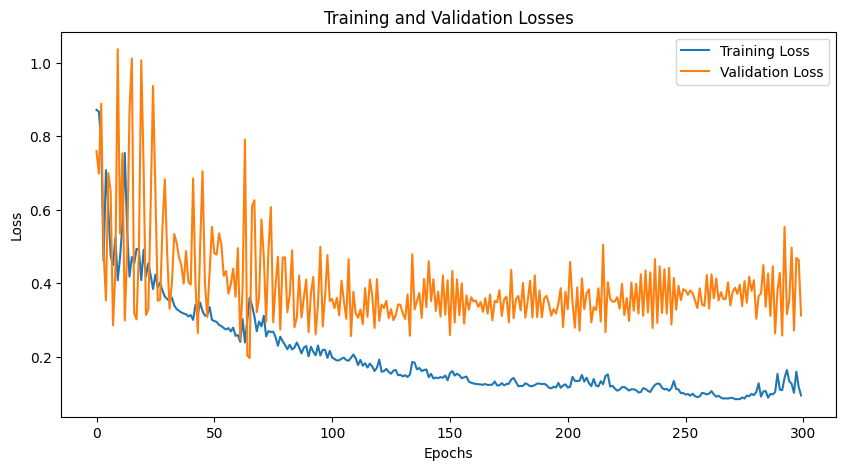

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [40]:
model.eval()  # Set the model to evaluation mode
test_loss = 0.0

with torch.no_grad():
    for images in test_loader:
        img = images['ct_generated'].float().to(device)
        std_map = images['std_map'].float().to(device)

        y_pred = model(img)
        loss = average_relative_error(y_pred, std_map)
        test_loss += loss.item() * img.size(0)

test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 0.4268


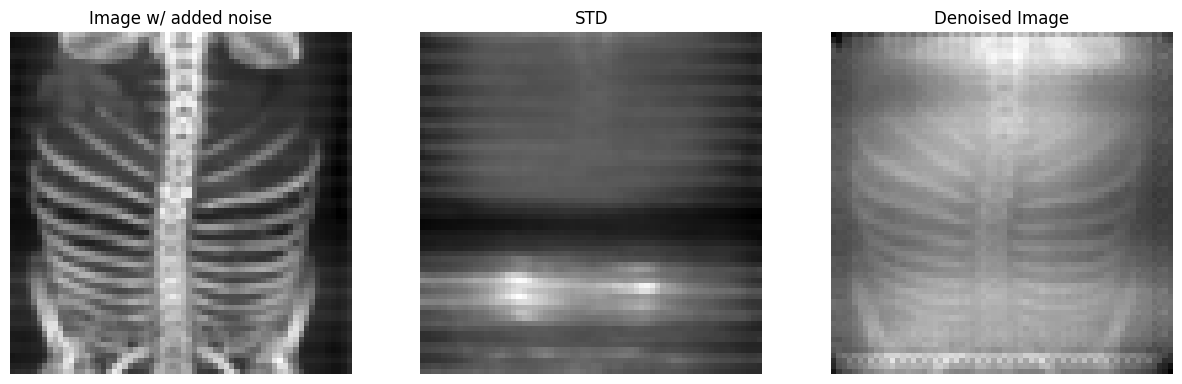

In [41]:
# model in evaluation mode
model.eval()

# get a batch from the test dataset
test_iter = iter(test_loader)
images = next(test_iter)

noisy_image = images['ct_generated'].float() 
std_image = images['std_map'].float() 

# select the first image in the batch
noisy_image_single = noisy_image[0].unsqueeze(0).to(device)  
std_image_single = std_image[0].to(device)

# Pass the noisy image through the model
with torch.no_grad():
    denoised_image = model(noisy_image_single)

# Move images back to CPU for visualization
noisy_image_cpu = noisy_image_single.squeeze(0).cpu() 
denoised_image_cpu = denoised_image.squeeze(0).cpu()
std_image_cpu = std_image_single.cpu()

# Plotting the images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(noisy_image_cpu[0], cmap='gray') 
plt.title('Image w/ added noise')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(std_image_cpu[0], cmap='gray')  
plt.title('STD')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(denoised_image_cpu[0], cmap='gray') 
plt.title('Denoised Image')
plt.axis('off')


plt.show()
# use fourier domain for denoising